# Installing Libraries

In [1]:
pip install adtk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00


In [2]:
pip install deel

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 9.0 MB/s eta 0:00:00
  Created wheel for deel: filename=deel-0.0.4.5-py3-none-any.whl size=46983 sha256=0a34a99961d539e7f5db3e778c598f885e105300b24532ceb2f718c812b3ead6
  Stored in directory: /root/.cache/pip/wheels/01/24/d7/0abb52901d25818f46a0ac1943e7f38bc198f54ad9fb4b6463
  Created wheel for chainer: filename=chainer-7.8.1-py3-none-any.whl size=971816 sha256=d80322d9c41d0ff2d0c4e4bffb5b380ee687108f216a373254b6e5a7a4ea3556
  Stored in directory: /root/.cache/pip/wheels/c4/95/6a/16014db6f761c4e742755b64aac60dbe142da1df6c5919f790
Successfully built deel chainer


In [3]:
pip install puncc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.8/70.8 kB 4.2 MB/s eta 0:00:00


# Importing Libraries

In [4]:
import os
import numpy as np
import pandas as pd
import warnings
import yfinance as yf
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support,confusion_matrix,f1_score,precision_score,recall_score,accuracy_score,roc_auc_score
from deel.puncc.anomaly_detection import SplitCAD
from deel.puncc.api.prediction import BasePredictor
from adtk.detector import QuantileAD,ThresholdAD,GeneralizedESDTestAD,RegressionAD,InterQuartileRangeAD
from adtk.visualization import plot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.express as px
import statsmodels.api as sm

warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

pio.renderers.default = 'colab'

# Fetching data

In [5]:
df = yf.download('^DJI', start='2020-01-01', end='2024-10-31')
df = df['Volume']
df1 = df.reset_index()
df1.rename(columns={"^DJI": "Volume"}, inplace=True)
df1['Volume']=df1['Volume']/1000000
print(df1.shape)
df1.head()

[*********************100%***********************]  1 of 1 completed

(1216, 2)


Ticker,Date,Volume
0,2020-01-02,251.82
1,2020-01-03,239.59
2,2020-01-06,252.76
3,2020-01-07,258.90
4,2020-01-08,291.75


# Data pre-processing

In [6]:
df1['Date']=pd.to_datetime(df1['Date'])
df_train = df1[(df1['Date'] >= '2020-01-01') & (df1['Date'] <= '2023-12-31')]
df_test = df1[(df1['Date'] >= '2024-01-01')]

print("Train Data Shape:", df_train.shape)
print("Test Data Shape:", df_test.shape)

df_train["Flag"] = np.where((df_train["Volume"] >= 250) & (df_train["Volume"] <= 500), 0, 1)
df_test["Flag"] = np.where((df_test["Volume"] >= 250) & (df_test["Volume"] <= 500), 0, 1)

df1=pd.concat([df_train,df_test],axis=0)
print("Train Data : ",df_train['Flag'].value_counts())
print("Test Data : ",df_test['Flag'].value_counts())

Train Data Shape: (1006, 2)
Test Data Shape: (210, 2)
Train Data :  Flag
0    861
1    145
Name: count, dtype: int64
Test Data :  Flag
0    197
1     13
Name: count, dtype: int64


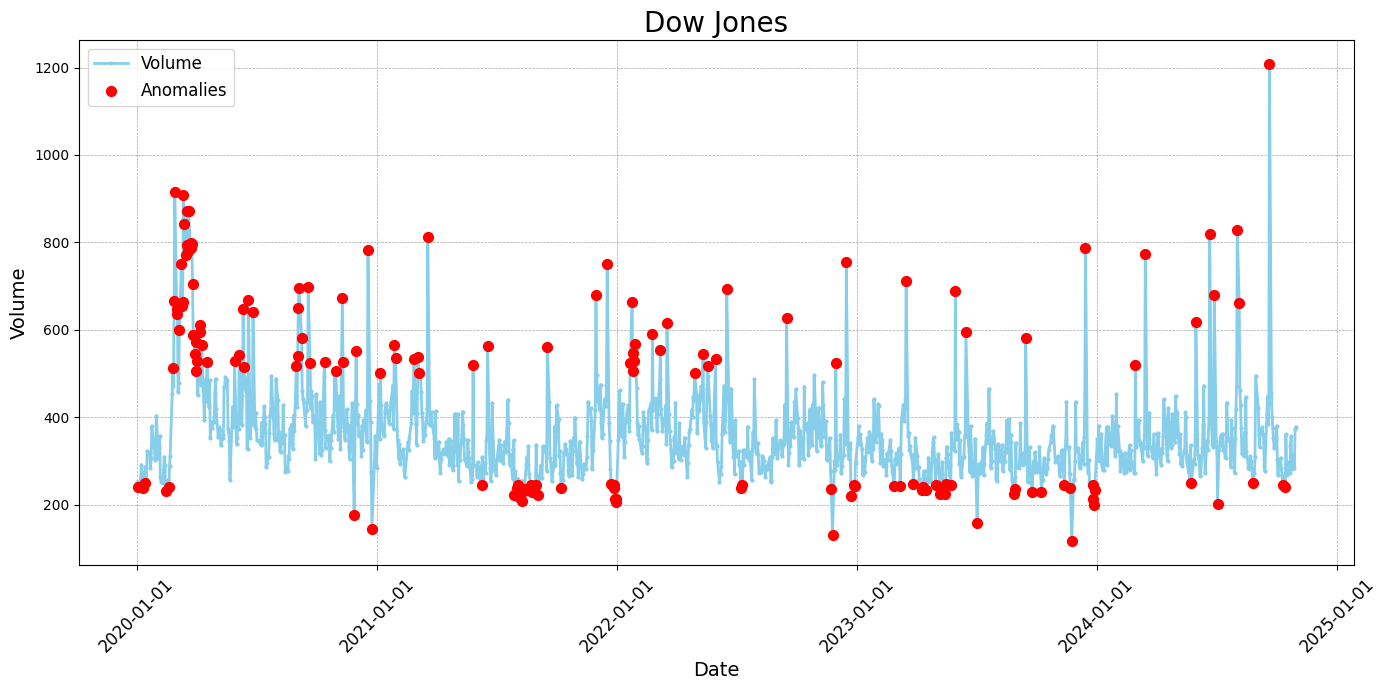

In [7]:
df1['Date'] = pd.to_datetime(df1['Date'])

fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(df1['Date'], df1['Volume'], label='Volume', color='skyblue', linewidth=2, marker='o', markersize=2)
anomalies = df1[df1['Flag'] == 1]
ax.scatter(anomalies['Date'], anomalies['Volume'], label='Anomalies', color='red', s=50, zorder=5)
ax.set_title('Dow Jones', fontsize=20, color='black')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Volume', fontsize=14)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(fontsize=12, rotation=45)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
ax.legend(fontsize=12, framealpha=0.8)
plt.tight_layout()
plt.show()

In [8]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Training Data (2020-2023)", "Testing Data (2024)"))
fig.add_trace(
    go.Scatter(
        x=df_train["Date"],
        y=df_train["Volume"],
        mode="lines+markers",
        name="Volume (Train)",
        line=dict(color="skyblue", width=2),
        marker=dict(size=2, color="skyblue") ),row=1, col=1)
fig.add_trace(
    go.Scatter(
        x=df_train[df_train["Flag"] == 1]["Date"],
        y=df_train[df_train["Flag"] == 1]["Volume"],
        mode="markers",
        name="Flag=1 (Train)",
        marker=dict(color="red", size=5, symbol="circle"),),row=1, col=1)
fig.add_trace(
    go.Scatter(
        x=df_test["Date"],
        y=df_test["Volume"],
        mode="lines+markers",
        name="Volume (Test)",
        line=dict(color="darkgreen", width=2),
        marker=dict(size=2, color="darkgreen") ),row=1, col=2)
fig.add_trace(
    go.Scatter(
        x=df_test[df_test["Flag"] == 1]["Date"],
        y=df_test[df_test["Flag"] == 1]["Volume"],
        mode="markers",
        name="Flag=1 (Test)",
        marker=dict(color="red", size=5, symbol="circle"),),row=1, col=2)
fig.update_layout(
    height=700,
    width=1700,
    title=dict(
        text="Dow Jones Volume with Flags (Train vs Test)",
        font=dict(size=20, color="black"),
        x=0.5),
    xaxis=dict(
        title="Date",
        titlefont=dict(size=14),
        tickfont=dict(size=12),
        showgrid=True,),
    yaxis=dict(
        title="Volume",
        titlefont=dict(size=14),
        tickfont=dict(size=12),
        showgrid=True,),
    legend=dict(
        font=dict(size=12),
        bgcolor="rgba(255, 255, 255, 0.8)"),
    template="plotly_white",
    plot_bgcolor="rgba(240, 248, 255, 0.9)")

fig.update_annotations(font=dict(size=14))
fig.show()

# Quantile AD

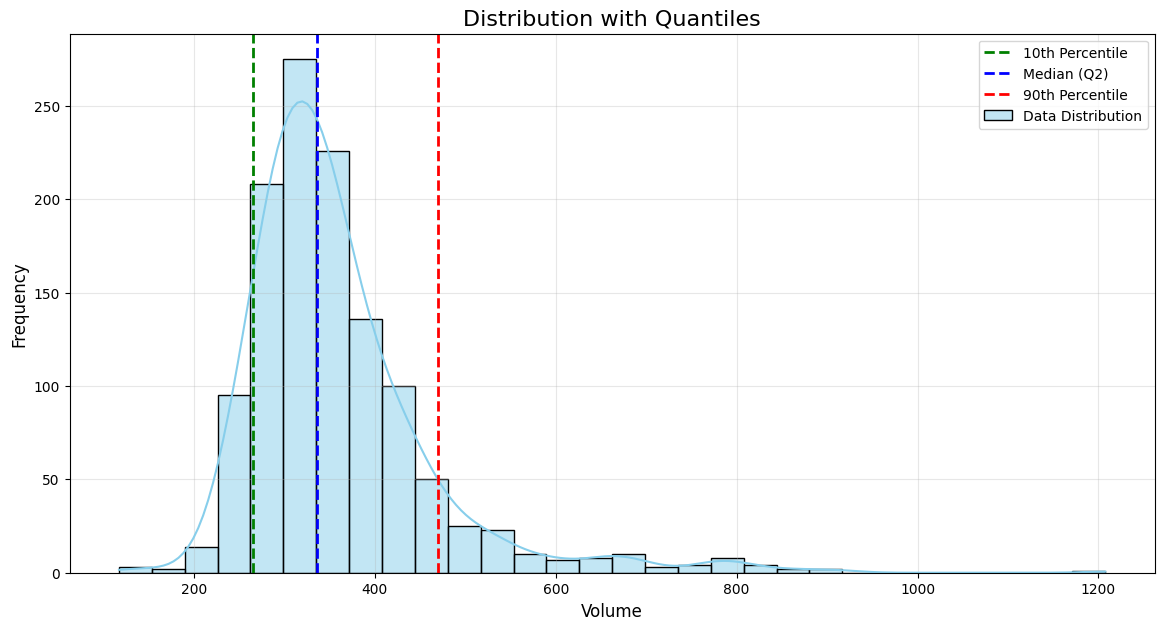

In [9]:
data = df1['Volume']

q1 = np.percentile(data, 10)
q2 = np.percentile(data, 50)
q3 = np.percentile(data, 90)
plt.figure(figsize=(14, 7))
sns.histplot(data, bins=30, kde=True, color="skyblue", label="Data Distribution")
for q, color, label in zip(
    [q1, q2, q3],
    ["green", "blue", "red"],
    ["10th Percentile", "Median (Q2)", "90th Percentile"]
):
    plt.axvline(q, color=color, linestyle="--", linewidth=2, label=label)
plt.title("Distribution with Quantiles", fontsize=16)
plt.xlabel("Volume", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()

In [10]:
df_train.set_index('Date', inplace=True)
df_test.set_index('Date', inplace=True)

Quantile_AD = QuantileAD(high=0.9, low=0.1)
Quantile_AD.fit(df_train[['Volume']])
df_train['anomaly_quantile'] = Quantile_AD.predict(df_train[['Volume']])
df_test['anomaly_quantile'] = Quantile_AD.predict(df_test[['Volume']])
df_train.reset_index('Date', inplace=True)
df_test.reset_index('Date', inplace=True)
df_train['anomaly_quantile'] = (df_train['anomaly_quantile'] == 1).astype(int)
df_test['anomaly_quantile'] = (df_test['anomaly_quantile'] == 1).astype(int)
print(f"Train Data Shape: {df_train.shape}")
print(f"Test Data Shape: {df_test.shape}")
df_train.head()

Train Data Shape: (1006, 4)
Test Data Shape: (210, 4)


Ticker,Date,Volume,Flag,anomaly_quantile
0,2020-01-02,251.82,0,1
1,2020-01-03,239.59,1,1
2,2020-01-06,252.76,0,1
3,2020-01-07,258.90,0,1
4,2020-01-08,291.75,0,0



Evaluation Metrics:
F1 Score: 0.90
Precision: 0.81
Recall: 1.00
Accuracy: 0.99


<ipython-input-11-3699d4057827>:20: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

<ipython-input-11-3699d4057827>:21: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



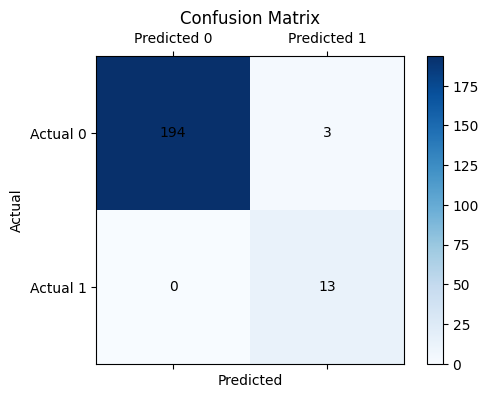

In [11]:
true_labels = df_test["Flag"]
predicted_labels = df_test["anomaly_quantile"]

cm = confusion_matrix(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
print("\nEvaluation Metrics:")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Accuracy: {accuracy:.2f}")
fig, ax = plt.subplots(figsize=(6, 4))
cax = ax.matshow(cm, cmap="Blues")
fig.colorbar(cax)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix")
ax.set_xticklabels(["", "Predicted 0", "Predicted 1"])
ax.set_yticklabels(["", "Actual 0", "Actual 1"])
for (i, j), value in np.ndenumerate(cm):
    ax.text(j, i, str(value), ha='center', va='center', color='black')
plt.show()

In [12]:
def evaluate_model(true_labels, predicted_labels):
    f1 = f1_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    return f1, precision, recall, accuracy
test_true_labels = df_test["Flag"]
test_predicted_labels = df_test["anomaly_quantile"]
test_metrics = evaluate_model(test_true_labels, test_predicted_labels)
train_true_labels = df_train["Flag"]
train_predicted_labels = df_train["anomaly_quantile"]
train_metrics = evaluate_model(train_true_labels, train_predicted_labels)
df_metrics=pd.DataFrame()
metrics = pd.DataFrame({
    "Model": ["Quantile AD", "Quantile AD"],
    "Data": ["Train", "Test"],
    "F1 Score": [train_metrics[0], test_metrics[0]],
    "Precision": [train_metrics[1], test_metrics[1]],
    "Recall": [train_metrics[2], test_metrics[2]],
    "Accuracy": [train_metrics[3], test_metrics[3]]})
df_metrics=pd.concat([df_metrics,metrics],axis=0)
df_metrics

,Model,Data,F1 Score,Precision,Recall,Accuracy
0,Quantile AD,Train,0.835735,0.717822,1.0,0.943340
1,Quantile AD,Test,0.896552,0.812500,1.0,0.985714


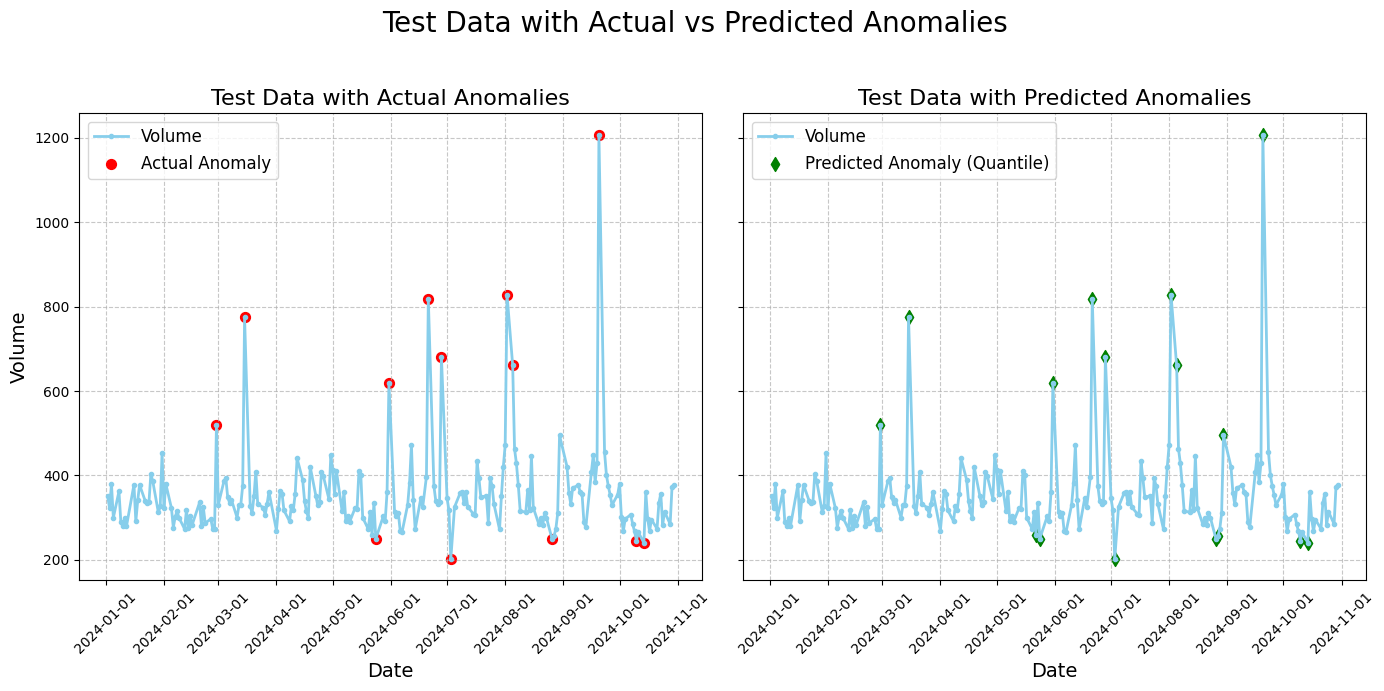

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
fig.suptitle("Test Data with Actual vs Predicted Anomalies", fontsize=20)
axes[0].plot(df_test["Date"], df_test["Volume"], label="Volume", color="skyblue", linewidth=2, marker='o', markersize=3)
actual_anomalies = df_test[df_test["Flag"] == 1]
axes[0].scatter(actual_anomalies["Date"], actual_anomalies["Volume"], label="Actual Anomaly", color="red", s=50)
axes[0].set_title("Test Data with Actual Anomalies", fontsize=16)
axes[0].set_xlabel("Date", fontsize=14)
axes[0].set_ylabel("Volume", fontsize=14)
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[0].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[0].tick_params(axis='x', labelrotation=45)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend(loc="upper left", fontsize=12)
axes[1].plot(df_test["Date"], df_test["Volume"], label="Volume", color="skyblue", linewidth=2, marker='o', markersize=3)
predicted_anomalies = df_test[df_test["anomaly_quantile"] == 1]
axes[1].scatter(predicted_anomalies["Date"], predicted_anomalies["Volume"], label="Predicted Anomaly (Quantile)", color="green", s=50, marker='d')
axes[1].set_title("Test Data with Predicted Anomalies", fontsize=16)
axes[1].set_xlabel("Date", fontsize=14)
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[1].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[1].tick_params(axis='x', labelrotation=45)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend(loc="upper left", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ESD

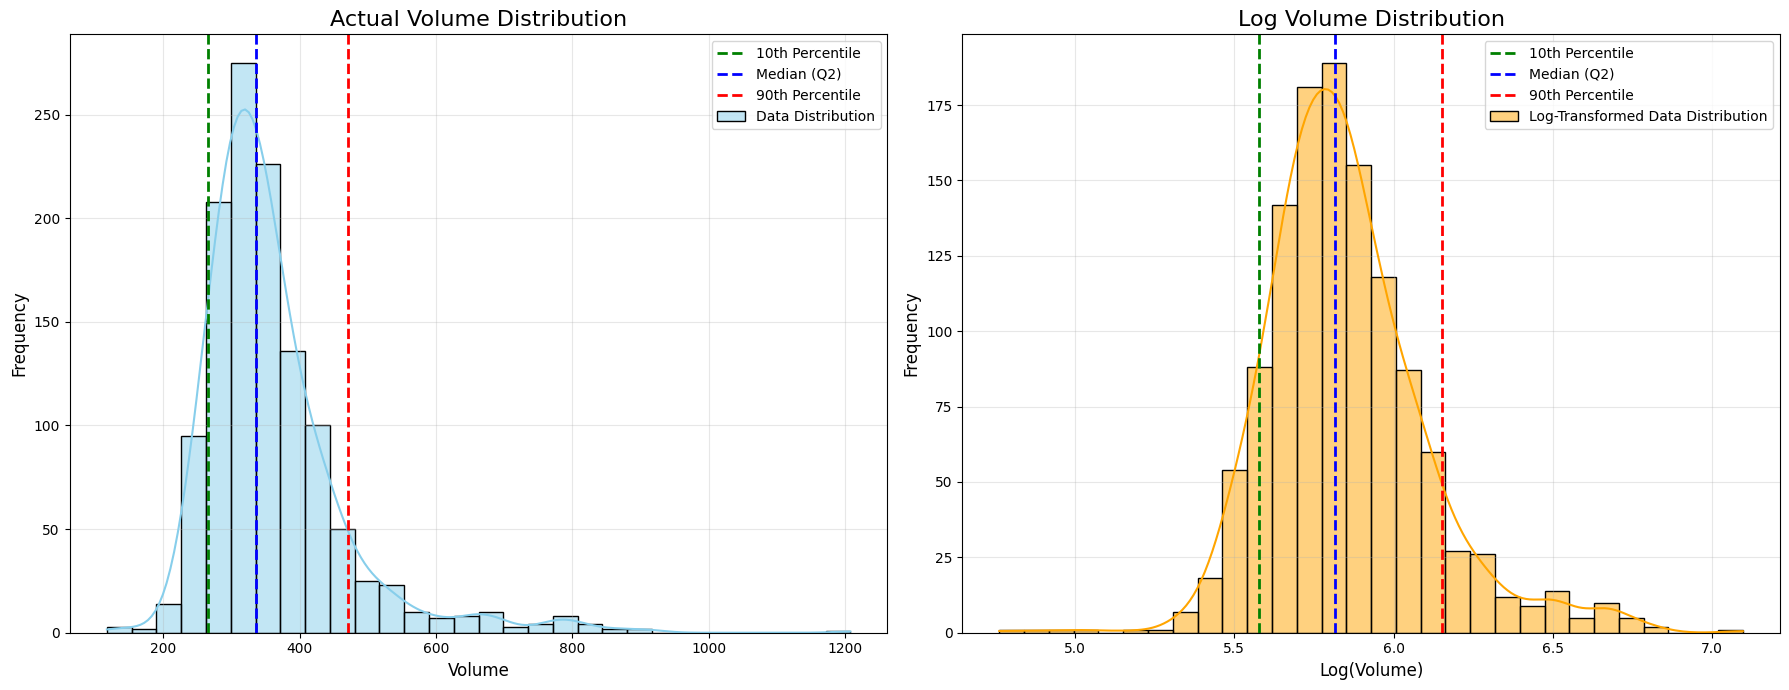

In [14]:
data = df1['Volume']
log_data = np.log(data)
q1_actual = np.percentile(data, 10)
q2_actual = np.percentile(data, 50)
q3_actual = np.percentile(data, 90)
q1_log = np.percentile(log_data, 10)
q2_log = np.percentile(log_data, 50)
q3_log = np.percentile(log_data, 90)
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
sns.histplot(data, bins=30, kde=True, color="skyblue", ax=axes[0], label="Data Distribution")
axes[0].set_title("Actual Volume Distribution", fontsize=16)
axes[0].set_xlabel("Volume", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)
sns.histplot(log_data, bins=30, kde=True, color="orange", ax=axes[1], label="Log-Transformed Data Distribution")
axes[1].set_title("Log Volume Distribution", fontsize=16)
axes[1].set_xlabel("Log(Volume)", fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)
axes[0].axvline(q1_actual, color="green", linestyle="--", linewidth=2, label="10th Percentile")
axes[0].axvline(q2_actual, color="blue", linestyle="--", linewidth=2, label="Median (Q2)")
axes[0].axvline(q3_actual, color="red", linestyle="--", linewidth=2, label="90th Percentile")
axes[1].axvline(q1_log, color="green", linestyle="--", linewidth=2, label="10th Percentile")
axes[1].axvline(q2_log, color="blue", linestyle="--", linewidth=2, label="Median (Q2)")
axes[1].axvline(q3_log, color="red", linestyle="--", linewidth=2, label="90th Percentile")
axes[0].legend(fontsize=10)
axes[1].legend(fontsize=10)
for ax in axes:
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
df_train.set_index('Date', inplace=True)
df_test.set_index('Date', inplace=True)
df_train[['Volume_log']]=np.log(df_train[['Volume']])
df_test[['Volume_log']]=np.log(df_test[['Volume']])
esd =GeneralizedESDTestAD(alpha=0.6)
esd.fit(df_train[['Volume_log']])
df_train['anomaly_ESD'] = esd.predict(df_train[['Volume_log']])
df_test['anomaly_ESD'] = esd.predict(df_test[['Volume_log']])
df_train['anomaly_ESD'] = (df_train['anomaly_ESD'] == 1).astype(int)
df_test['anomaly_ESD'] = (df_test['anomaly_ESD'] == 1).astype(int)
df_train.reset_index('Date', inplace=True)
df_test.reset_index('Date', inplace=True)
print(f"Train Data Shape: {df_train.shape}")
print(f"Test Data Shape: {df_test.shape}")
df_train.head()

Train Data Shape: (1006, 6)
Test Data Shape: (210, 6)


Ticker,Date,Volume,Flag,anomaly_quantile,Volume_log,anomaly_ESD
0,2020-01-02,251.82,0,1,5.528715,0
1,2020-01-03,239.59,1,1,5.478929,0
2,2020-01-06,252.76,0,1,5.532440,0
3,2020-01-07,258.90,0,1,5.556442,0
4,2020-01-08,291.75,0,0,5.675897,0


In [16]:
df_test['anomaly_ESD'].value_counts()

,count
anomaly_ESD,
0,206
1,4



Evaluation Metrics:
F1 Score: 0.47
Precision: 1.00
Recall: 0.31
Accuracy: 0.96


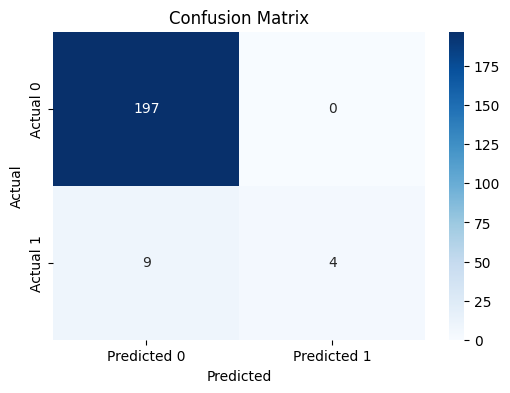

In [17]:
true_labels = df_test["Flag"]
predicted_labels = df_test["anomaly_ESD"]
cm = confusion_matrix(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
print("\nEvaluation Metrics:")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Accuracy: {accuracy:.2f}")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [18]:
def evaluate_model(true_labels, predicted_labels):
    f1 = f1_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    return f1, precision, recall, accuracy
test_true_labels = df_test["Flag"]
test_predicted_labels = df_test["anomaly_ESD"]
test_metrics = evaluate_model(test_true_labels, test_predicted_labels)
train_true_labels = df_train["Flag"]
train_predicted_labels = df_train["anomaly_ESD"]
train_metrics = evaluate_model(train_true_labels, train_predicted_labels)
metrics = pd.DataFrame({
    "Model": ["ESD AD", "ESD AD"],
    "Data": ["Train", "Test"],
    "F1 Score": [train_metrics[0], test_metrics[0]],
    "Precision": [train_metrics[1], test_metrics[1]],
    "Recall": [train_metrics[2], test_metrics[2]],
    "Accuracy": [train_metrics[3], test_metrics[3]]})
df_metrics=pd.concat([df_metrics,metrics],axis=0)
df_metrics

,Model,Data,F1 Score,Precision,Recall,Accuracy
0,Quantile AD,Train,0.835735,0.717822,1.000000,0.943340
1,Quantile AD,Test,0.896552,0.812500,1.000000,0.985714
0,ESD AD,Train,0.209877,1.000000,0.117241,0.872763
1,ESD AD,Test,0.470588,1.000000,0.307692,0.957143


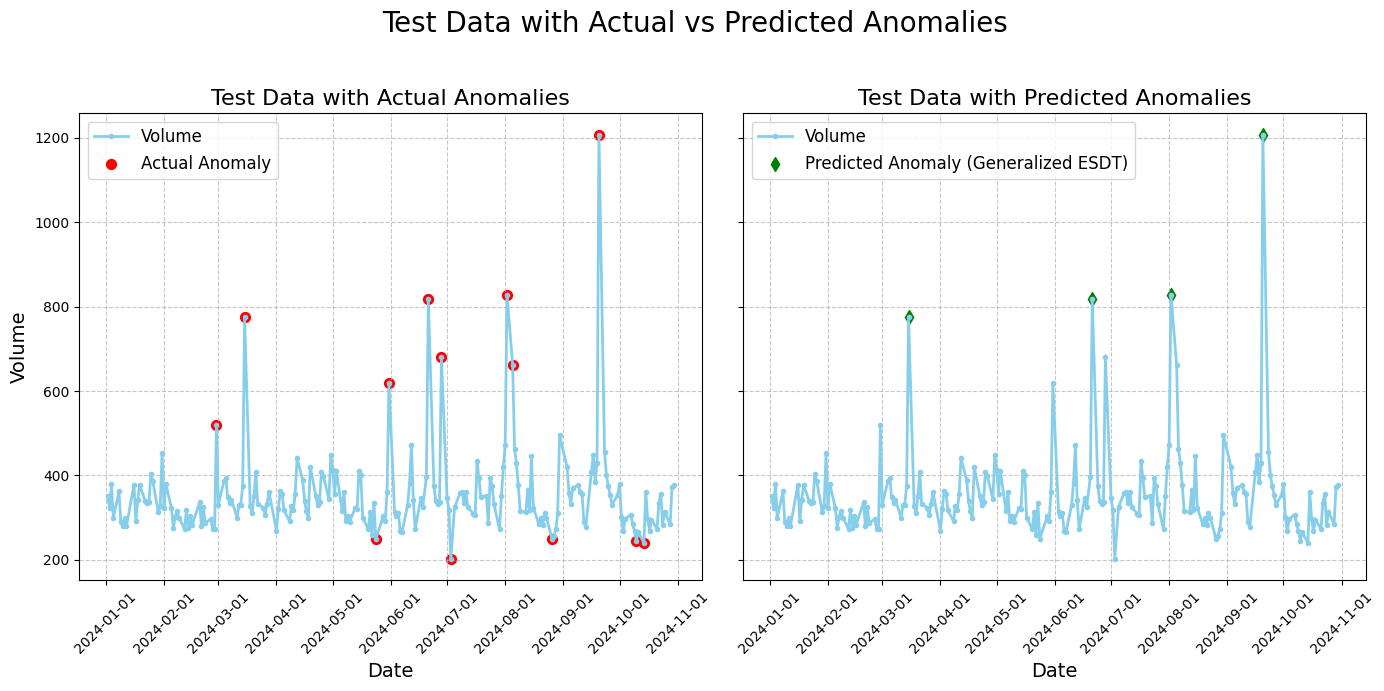

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
fig.suptitle("Test Data with Actual vs Predicted Anomalies", fontsize=20)
axes[0].plot(df_test["Date"], df_test["Volume"], label="Volume", color="skyblue", linewidth=2, marker='o', markersize=3)
actual_anomalies = df_test[df_test["Flag"] == 1]
axes[0].scatter(actual_anomalies["Date"], actual_anomalies["Volume"], label="Actual Anomaly", color="red", s=50)
axes[0].set_title("Test Data with Actual Anomalies", fontsize=16)
axes[0].set_xlabel("Date", fontsize=14)
axes[0].set_ylabel("Volume", fontsize=14)
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[0].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[0].tick_params(axis='x', labelrotation=45)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend(loc="upper left", fontsize=12)
axes[1].plot(df_test["Date"], df_test["Volume"], label="Volume", color="skyblue", linewidth=2, marker='o', markersize=3)
predicted_anomalies = df_test[df_test["anomaly_ESD"] == 1]
axes[1].scatter(predicted_anomalies["Date"], predicted_anomalies["Volume"], label="Predicted Anomaly (Generalized ESDT)", color="green", s=50, marker='d')
axes[1].set_title("Test Data with Predicted Anomalies", fontsize=16)
axes[1].set_xlabel("Date", fontsize=14)
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[1].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[1].tick_params(axis='x', labelrotation=45)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend(loc="upper left", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Isolation Forest

In [20]:
iso_forest = IsolationForest(contamination=0.09)
iso_forest.fit(df_train[['Volume']])
df_train['anomaly_isolation_forest'] = iso_forest.predict(df_train[['Volume']])
df_test['anomaly_isolation_forest'] = iso_forest.predict(df_test[['Volume']])
df_train['anomaly_isolation_forest'] = (df_train['anomaly_isolation_forest'] == -1).astype(int)
df_test['anomaly_isolation_forest'] = (df_test['anomaly_isolation_forest'] == -1).astype(int)
print(f"Train Data Shape: {df_train.shape}")
print(f"Test Data Shape: {df_test.shape}")
df_train.head()

Train Data Shape: (1006, 7)
Test Data Shape: (210, 7)


Ticker,Date,Volume,Flag,anomaly_quantile,Volume_log,anomaly_ESD,anomaly_isolation_forest
0,2020-01-02,251.82,0,1,5.528715,0,0
1,2020-01-03,239.59,1,1,5.478929,0,0
2,2020-01-06,252.76,0,1,5.532440,0,0
3,2020-01-07,258.90,0,1,5.556442,0,0
4,2020-01-08,291.75,0,0,5.675897,0,0



Evaluation Metrics:
F1 Score: 0.82
Precision: 1.00
Recall: 0.69
Accuracy: 0.98


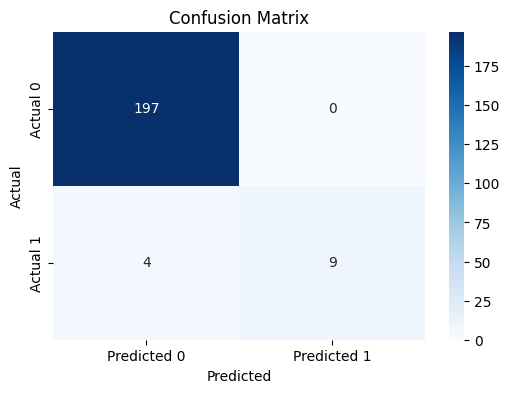

In [21]:
true_labels = df_test["Flag"]
predicted_labels = df_test["anomaly_isolation_forest"]
cm = confusion_matrix(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
print("\nEvaluation Metrics:")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Accuracy: {accuracy:.2f}")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [22]:
def evaluate_model(true_labels, predicted_labels):
    f1 = f1_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    return f1, precision, recall, accuracy
test_true_labels = df_test["Flag"]
test_predicted_labels = df_test["anomaly_isolation_forest"]
test_metrics = evaluate_model(test_true_labels, test_predicted_labels)
train_true_labels = df_train["Flag"]
train_predicted_labels = df_train["anomaly_isolation_forest"]
train_metrics = evaluate_model(train_true_labels, train_predicted_labels)
metrics = pd.DataFrame({
    "Model": ["Isolation Forest AD", "Isolation Forest AD"],
    "Data": ["Train", "Test"],
    "F1 Score": [train_metrics[0], test_metrics[0]],
    "Precision": [train_metrics[1], test_metrics[1]],
    "Recall": [train_metrics[2], test_metrics[2]],
    "Accuracy": [train_metrics[3], test_metrics[3]]})
df_metrics=pd.concat([df_metrics,metrics],axis=0)
df_metrics

,Model,Data,F1 Score,Precision,Recall,Accuracy
0,Quantile AD,Train,0.835735,0.717822,1.000000,0.943340
1,Quantile AD,Test,0.896552,0.812500,1.000000,0.985714
0,ESD AD,Train,0.209877,1.000000,0.117241,0.872763
1,ESD AD,Test,0.470588,1.000000,0.307692,0.957143
0,Isolation Forest AD,Train,0.771186,1.000000,0.627586,0.946322
1,Isolation Forest AD,Test,0.818182,1.000000,0.692308,0.980952


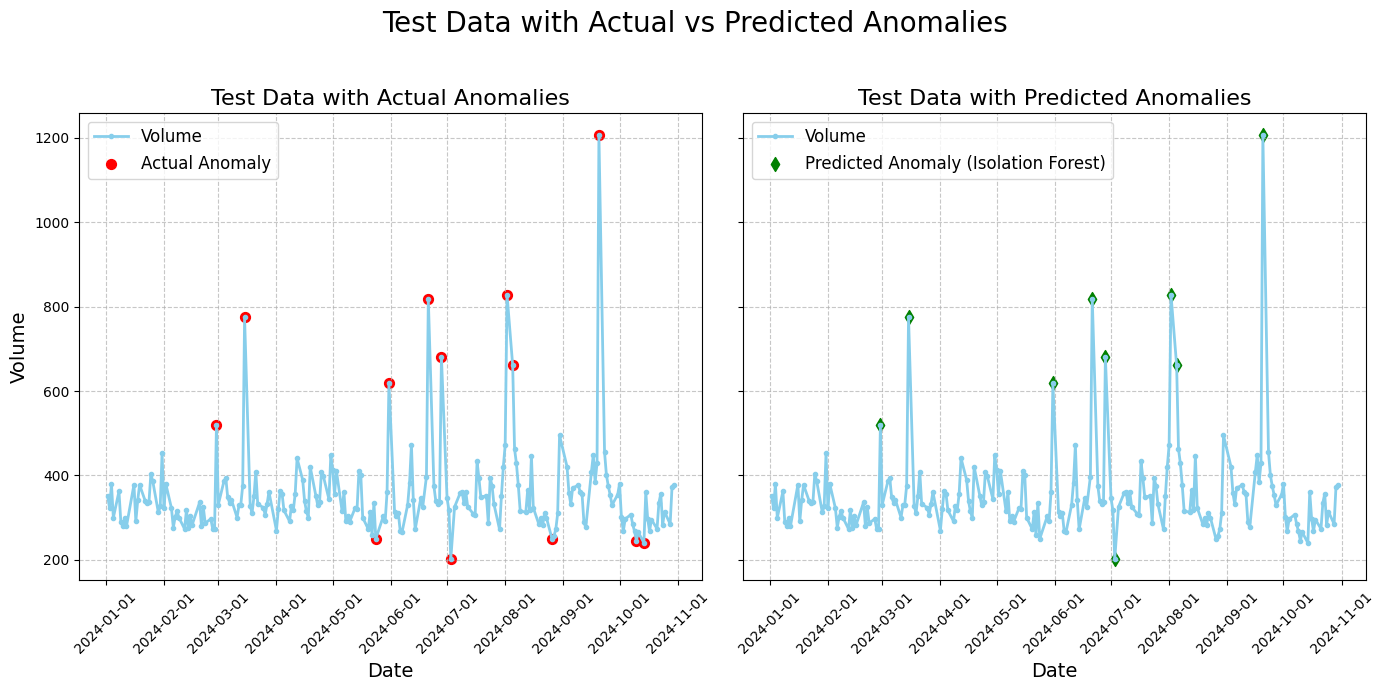

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
fig.suptitle("Test Data with Actual vs Predicted Anomalies", fontsize=20)
axes[0].plot(df_test["Date"], df_test["Volume"], label="Volume", color="skyblue", linewidth=2, marker='o', markersize=3)
actual_anomalies = df_test[df_test["Flag"] == 1]
axes[0].scatter(actual_anomalies["Date"], actual_anomalies["Volume"], label="Actual Anomaly", color="red", s=50)
axes[0].set_title("Test Data with Actual Anomalies", fontsize=16)
axes[0].set_xlabel("Date", fontsize=14)
axes[0].set_ylabel("Volume", fontsize=14)
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[0].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[0].tick_params(axis='x', labelrotation=45)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend(loc="upper left", fontsize=12)
axes[1].plot(df_test["Date"], df_test["Volume"], label="Volume", color="skyblue", linewidth=2, marker='o', markersize=3)
predicted_anomalies = df_test[df_test["anomaly_isolation_forest"] == 1]
axes[1].scatter(predicted_anomalies["Date"], predicted_anomalies["Volume"], label="Predicted Anomaly (Isolation Forest)", color="green", s=50, marker='d')
axes[1].set_title("Test Data with Predicted Anomalies", fontsize=16)
axes[1].set_xlabel("Date", fontsize=14)
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[1].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[1].tick_params(axis='x', labelrotation=45)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend(loc="upper left", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Isolation Forest + CAD

In [24]:
class ADPredictor(BasePredictor):
    def predict(self, X):
        return -self.model.score_samples(X)
if_predictor = ADPredictor(IsolationForest(contamination=0.09))
if_cad = SplitCAD(if_predictor, train=True, random_state=0)
if_cad.fit(z=df_train[["Volume"]], fit_ratio=0.7)
alpha = 0.08
train_cad_results = if_cad.predict(df_train[["Volume"]], alpha=alpha)
df_train['conformal_if'] = train_cad_results
test_cad_results = if_cad.predict(df_test[["Volume"]], alpha=alpha)
df_test['conformal_if'] = test_cad_results
df1 = pd.concat([df_train, df_test])
df_train['conformal_if'] = df_train['conformal_if'].replace({True: 1, False: 0})
df_test['conformal_if'] = df_test['conformal_if'].replace({True: 1, False: 0})
df1['conformal_if'] = df1['conformal_if'].astype(int)
df_train.head()

<ipython-input-24-6400b64af443>:13: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-24-6400b64af443>:14: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Ticker,Date,Volume,Flag,anomaly_quantile,Volume_log,anomaly_ESD,anomaly_isolation_forest,conformal_if
0,2020-01-02,251.82,0,1,5.528715,0,0,0
1,2020-01-03,239.59,1,1,5.478929,0,0,0
2,2020-01-06,252.76,0,1,5.532440,0,0,0
3,2020-01-07,258.90,0,1,5.556442,0,0,0
4,2020-01-08,291.75,0,0,5.675897,0,0,0



Evaluation Metrics:
F1 Score: 0.76
Precision: 1.00
Recall: 0.62
Accuracy: 0.98


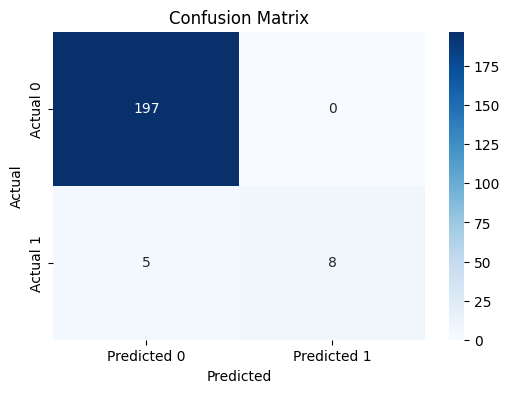

In [25]:
true_labels = df_test["Flag"]
predicted_labels = df_test["conformal_if"]
cm = confusion_matrix(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
print("\nEvaluation Metrics:")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Accuracy: {accuracy:.2f}")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

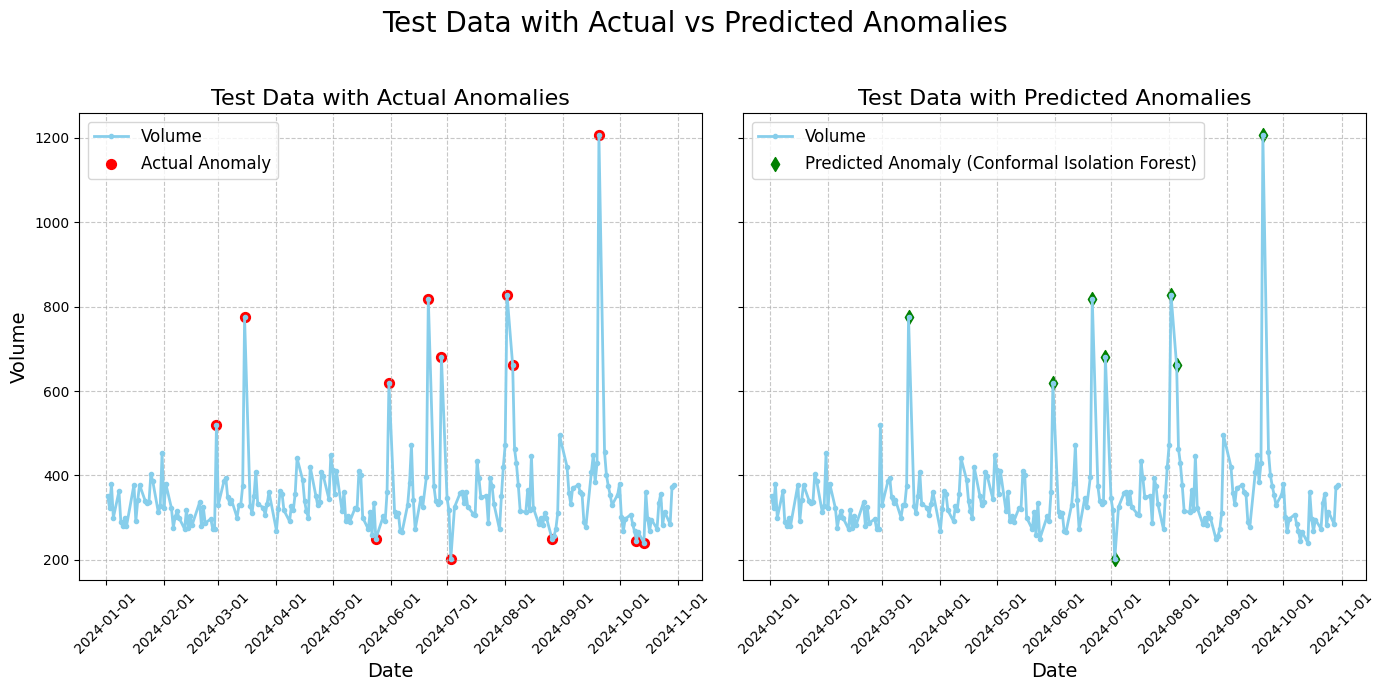

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
fig.suptitle("Test Data with Actual vs Predicted Anomalies", fontsize=20)
axes[0].plot(df_test["Date"], df_test["Volume"], label="Volume", color="skyblue", linewidth=2, marker='o', markersize=3)
actual_anomalies = df_test[df_test["Flag"] == 1]
axes[0].scatter(actual_anomalies["Date"], actual_anomalies["Volume"], label="Actual Anomaly", color="red", s=50)
axes[0].set_title("Test Data with Actual Anomalies", fontsize=16)
axes[0].set_xlabel("Date", fontsize=14)
axes[0].set_ylabel("Volume", fontsize=14)
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[0].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[0].tick_params(axis='x', labelrotation=45)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend(loc="upper left", fontsize=12)
axes[1].plot(df_test["Date"], df_test["Volume"], label="Volume", color="skyblue", linewidth=2, marker='o', markersize=3)
predicted_anomalies = df_test[df_test["conformal_if"] == 1]
axes[1].scatter(predicted_anomalies["Date"], predicted_anomalies["Volume"], label="Predicted Anomaly (Conformal Isolation Forest)", color="green", s=50, marker='d')
axes[1].set_title("Test Data with Predicted Anomalies", fontsize=16)
axes[1].set_xlabel("Date", fontsize=14)
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[1].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[1].tick_params(axis='x', labelrotation=45)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend(loc="upper left", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [27]:
def evaluate_model(true_labels, predicted_labels):
    f1 = f1_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    return f1, precision, recall, accuracy
test_true_labels = df_test["Flag"]
test_predicted_labels = df_test["conformal_if"]
test_metrics = evaluate_model(test_true_labels, test_predicted_labels)
train_true_labels = df_train["Flag"]
train_predicted_labels = df_train["conformal_if"]
train_metrics = evaluate_model(train_true_labels, train_predicted_labels)
metrics = pd.DataFrame({
    "Model": ["Isolation Forest (Conformal) AD", "Isolation Forest (Conformal) AD"],
    "Data": ["Train", "Test"],
    "F1 Score": [train_metrics[0], test_metrics[0]],
    "Precision": [train_metrics[1], test_metrics[1]],
    "Recall": [train_metrics[2], test_metrics[2]],
    "Accuracy": [train_metrics[3], test_metrics[3]]})
df_metrics=pd.concat([df_metrics,metrics],axis=0)
df_metrics

,Model,Data,F1 Score,Precision,Recall,Accuracy
0,Quantile AD,Train,0.835735,0.717822,1.000000,0.943340
1,Quantile AD,Test,0.896552,0.812500,1.000000,0.985714
0,ESD AD,Train,0.209877,1.000000,0.117241,0.872763
1,ESD AD,Test,0.470588,1.000000,0.307692,0.957143
0,Isolation Forest AD,Train,0.771186,1.000000,0.627586,0.946322
1,Isolation Forest AD,Test,0.818182,1.000000,0.692308,0.980952
0,Isolation Forest (Conformal) AD,Train,0.675799,1.000000,0.510345,0.929423
1,Isolation Forest (Conformal) AD,Test,0.761905,1.000000,0.615385,0.976190


# One class SVM

In [28]:
scaler = MinMaxScaler()
columns_to_scale = ['Volume']
df_train['Volume_scaled'] = scaler.fit_transform(df_train[columns_to_scale])
df_test['Volume_scaled'] = scaler.transform(df_test[columns_to_scale])

In [29]:
ocsvm = OneClassSVM(
    kernel='rbf',
    nu=0.15,
    gamma='auto'            )
ocsvm.fit(df_train[['Volume_scaled']])
df_train['anomaly_ocsvm'] = ocsvm.predict(df_train[['Volume_scaled']])
df_test['anomaly_ocsvm'] = ocsvm.predict(df_test[['Volume_scaled']])
df_train['anomaly_ocsvm'] = (df_train['anomaly_ocsvm'] == -1).astype(int)
df_test['anomaly_ocsvm'] = (df_test['anomaly_ocsvm'] == -1).astype(int)
print(f"Train Data Shape: {df_train.shape}")
print(f"Test Data Shape: {df_test.shape}")
df_train.head()

Train Data Shape: (1006, 10)
Test Data Shape: (210, 10)


Ticker,Date,Volume,Flag,anomaly_quantile,Volume_log,anomaly_ESD,anomaly_isolation_forest,conformal_if,Volume_scaled,anomaly_ocsvm
0,2020-01-02,251.82,0,1,5.528715,0,0,0,0.168696,1
1,2020-01-03,239.59,1,1,5.478929,0,0,0,0.153389,1
2,2020-01-06,252.76,0,1,5.532440,0,0,0,0.169873,1
3,2020-01-07,258.90,0,1,5.556442,0,0,0,0.177558,0
4,2020-01-08,291.75,0,0,5.675897,0,0,0,0.218675,0



Evaluation Metrics:
F1 Score: 0.92
Precision: 0.92
Recall: 0.92
Accuracy: 0.99


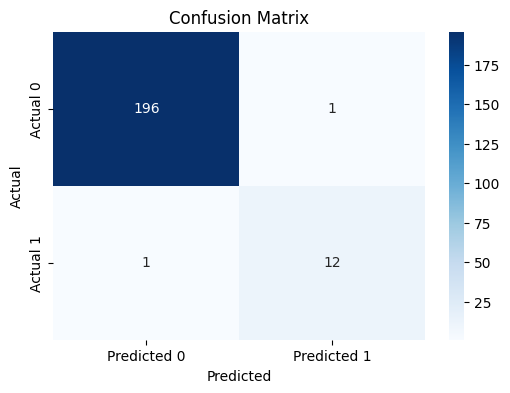

In [30]:
true_labels = df_test["Flag"]
predicted_labels = df_test["anomaly_ocsvm"]
cm = confusion_matrix(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
print("\nEvaluation Metrics:")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Accuracy: {accuracy:.2f}")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [31]:
def evaluate_model(true_labels, predicted_labels):
    f1 = f1_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    return f1, precision, recall, accuracy
test_true_labels = df_test["Flag"]
test_predicted_labels = df_test["anomaly_ocsvm"]
test_metrics = evaluate_model(test_true_labels, test_predicted_labels)
train_true_labels = df_train["Flag"]
train_predicted_labels = df_train["anomaly_ocsvm"]
train_metrics = evaluate_model(train_true_labels, train_predicted_labels)
metrics = pd.DataFrame({
    "Model": ["One Class SVM AD", "One Class SVM AD"],
    "Data": ["Train", "Test"],
    "F1 Score": [train_metrics[0], test_metrics[0]],
    "Precision": [train_metrics[1], test_metrics[1]],
    "Recall": [train_metrics[2], test_metrics[2]],
    "Accuracy": [train_metrics[3], test_metrics[3]]})
df_metrics=pd.concat([df_metrics,metrics],axis=0)
df_metrics

,Model,Data,F1 Score,Precision,Recall,Accuracy
0,Quantile AD,Train,0.835735,0.717822,1.000000,0.943340
1,Quantile AD,Test,0.896552,0.812500,1.000000,0.985714
0,ESD AD,Train,0.209877,1.000000,0.117241,0.872763
1,ESD AD,Test,0.470588,1.000000,0.307692,0.957143
0,Isolation Forest AD,Train,0.771186,1.000000,0.627586,0.946322
1,Isolation Forest AD,Test,0.818182,1.000000,0.692308,0.980952
0,Isolation Forest (Conformal) AD,Train,0.675799,1.000000,0.510345,0.929423
1,Isolation Forest (Conformal) AD,Test,0.761905,1.000000,0.615385,0.976190
0,One Class SVM AD,Train,0.831081,0.814570,0.848276,0.950298
1,One Class SVM AD,Test,0.923077,0.923077,0.923077,0.990476


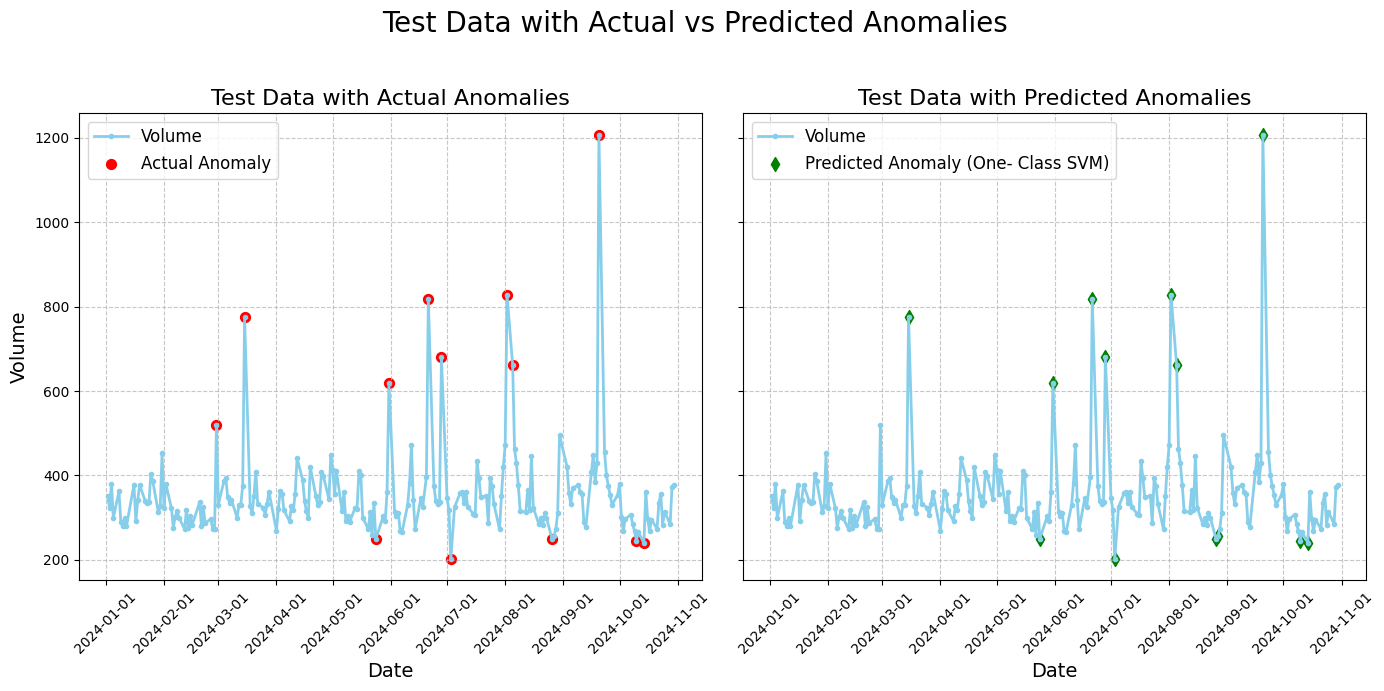

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
fig.suptitle("Test Data with Actual vs Predicted Anomalies", fontsize=20)
axes[0].plot(df_test["Date"], df_test["Volume"], label="Volume", color="skyblue", linewidth=2, marker='o', markersize=3)
actual_anomalies = df_test[df_test["Flag"] == 1]
axes[0].scatter(actual_anomalies["Date"], actual_anomalies["Volume"], label="Actual Anomaly", color="red", s=50)
axes[0].set_title("Test Data with Actual Anomalies", fontsize=16)
axes[0].set_xlabel("Date", fontsize=14)
axes[0].set_ylabel("Volume", fontsize=14)
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[0].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[0].tick_params(axis='x', labelrotation=45)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend(loc="upper left", fontsize=12)
axes[1].plot(df_test["Date"], df_test["Volume"], label="Volume", color="skyblue", linewidth=2, marker='o', markersize=3)
predicted_anomalies = df_test[df_test["anomaly_ocsvm"] == 1]
axes[1].scatter(predicted_anomalies["Date"], predicted_anomalies["Volume"], label="Predicted Anomaly (One- Class SVM)", color="green", s=50, marker='d')
axes[1].set_title("Test Data with Predicted Anomalies", fontsize=16)
axes[1].set_xlabel("Date", fontsize=14)
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[1].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[1].tick_params(axis='x', labelrotation=45)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend(loc="upper left", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# OC SVM +CAD

In [33]:
class ADPredictor(BasePredictor):
    def predict(self, X):
        return -self.model.score_samples(X)
if_predictor = ADPredictor(OneClassSVM(
    kernel='rbf',
    nu=0.15,
    gamma='auto' ))
if_cad = SplitCAD(if_predictor, train=True, random_state=0)
if_cad.fit(z=df_train[["Volume_scaled"]], fit_ratio=0.7)
alpha = 0.15
train_cad_results = if_cad.predict(df_train[["Volume_scaled"]], alpha=alpha)
df_train['conformal_OCSVM'] = train_cad_results
test_cad_results = if_cad.predict(df_test[["Volume_scaled"]], alpha=alpha)
df_test['conformal_OCSVM'] = test_cad_results
df1 = pd.concat([df_train, df_test])
df_train['conformal_OCSVM'] = df_train['conformal_OCSVM'].replace({True: 1, False: 0})
df_test['conformal_OCSVM'] = df_test['conformal_OCSVM'].replace({True: 1, False: 0})
df1['conformal_OCSVM'] = (df1['conformal_OCSVM'] == -1).astype(int)
df_train.head()

<ipython-input-33-4adc70d6c5de>:16: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-33-4adc70d6c5de>:17: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Ticker,Date,Volume,Flag,anomaly_quantile,Volume_log,anomaly_ESD,anomaly_isolation_forest,conformal_if,Volume_scaled,anomaly_ocsvm,conformal_OCSVM
0,2020-01-02,251.82,0,1,5.528715,0,0,0,0.168696,1,0
1,2020-01-03,239.59,1,1,5.478929,0,0,0,0.153389,1,1
2,2020-01-06,252.76,0,1,5.532440,0,0,0,0.169873,1,0
3,2020-01-07,258.90,0,1,5.556442,0,0,0,0.177558,0,0
4,2020-01-08,291.75,0,0,5.675897,0,0,0,0.218675,0,0



Evaluation Metrics:
F1 Score: 0.92
Precision: 1.00
Recall: 0.85
Accuracy: 0.99


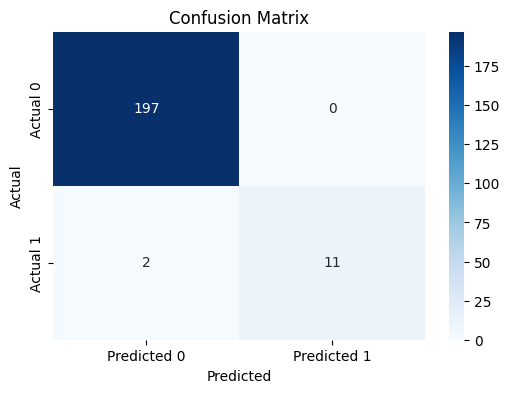

In [34]:
true_labels = df_test["Flag"]
predicted_labels = df_test["conformal_OCSVM"]
cm = confusion_matrix(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
print("\nEvaluation Metrics:")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Accuracy: {accuracy:.2f}")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [35]:
def evaluate_model(true_labels, predicted_labels):
    f1 = f1_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    return f1, precision, recall, accuracy
test_true_labels = df_test["Flag"]
test_predicted_labels = df_test["conformal_OCSVM"]
test_metrics = evaluate_model(test_true_labels, test_predicted_labels)
train_true_labels = df_train["Flag"]
train_predicted_labels = df_train["conformal_OCSVM"]
train_metrics = evaluate_model(train_true_labels, train_predicted_labels)
metrics = pd.DataFrame({
    "Model": ["One Class SVM (Conformal) AD", "One Class SVM (Conformal) AD"],
    "Data": ["Train", "Test"],
    "F1 Score": [train_metrics[0], test_metrics[0]],
    "Precision": [train_metrics[1], test_metrics[1]],
    "Recall": [train_metrics[2], test_metrics[2]],
    "Accuracy": [train_metrics[3], test_metrics[3]]})
df_metrics=pd.concat([df_metrics,metrics],axis=0)
df_metrics

,Model,Data,F1 Score,Precision,Recall,Accuracy
0,Quantile AD,Train,0.835735,0.717822,1.000000,0.943340
1,Quantile AD,Test,0.896552,0.812500,1.000000,0.985714
0,ESD AD,Train,0.209877,1.000000,0.117241,0.872763
1,ESD AD,Test,0.470588,1.000000,0.307692,0.957143
0,Isolation Forest AD,Train,0.771186,1.000000,0.627586,0.946322
1,Isolation Forest AD,Test,0.818182,1.000000,0.692308,0.980952
0,Isolation Forest (Conformal) AD,Train,0.675799,1.000000,0.510345,0.929423
1,Isolation Forest (Conformal) AD,Test,0.761905,1.000000,0.615385,0.976190
0,One Class SVM AD,Train,0.831081,0.814570,0.848276,0.950298
1,One Class SVM AD,Test,0.923077,0.923077,0.923077,0.990476


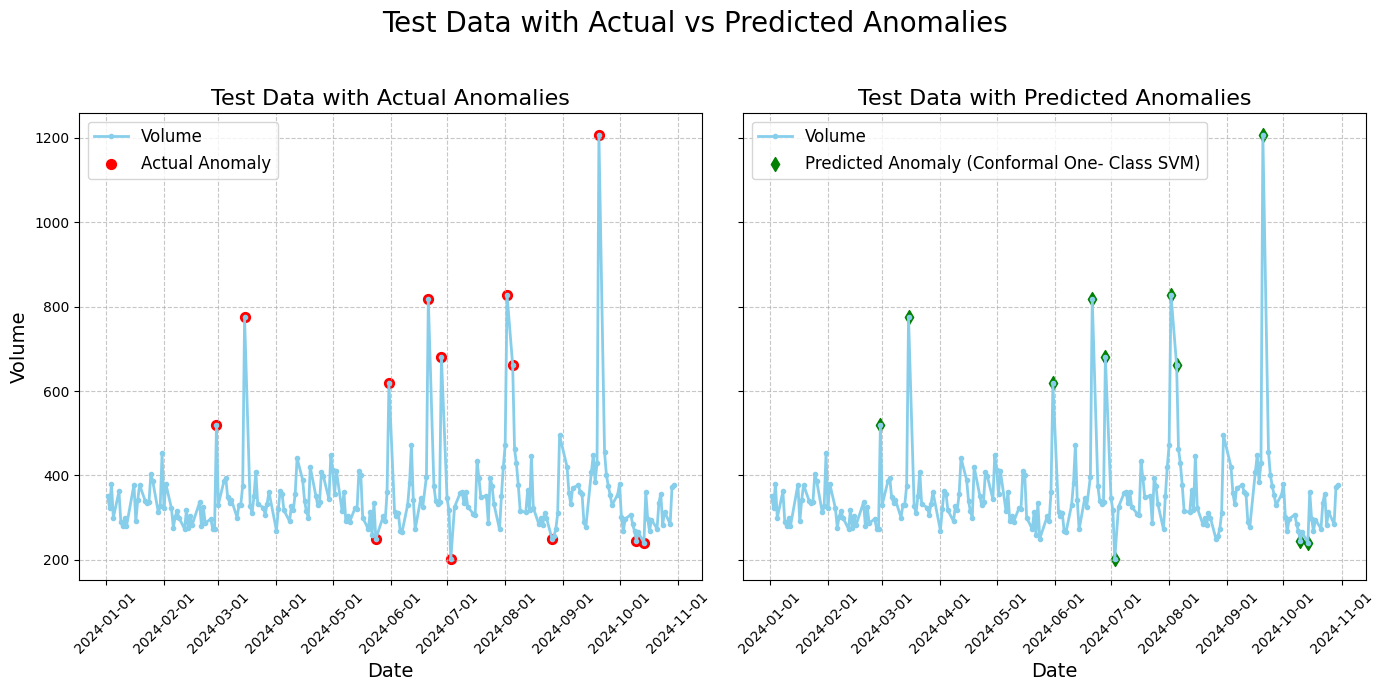

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
fig.suptitle("Test Data with Actual vs Predicted Anomalies", fontsize=20)
axes[0].plot(df_test["Date"], df_test["Volume"], label="Volume", color="skyblue", linewidth=2, marker='o', markersize=3)
actual_anomalies = df_test[df_test["Flag"] == 1]
axes[0].scatter(actual_anomalies["Date"], actual_anomalies["Volume"], label="Actual Anomaly", color="red", s=50)
axes[0].set_title("Test Data with Actual Anomalies", fontsize=16)
axes[0].set_xlabel("Date", fontsize=14)
axes[0].set_ylabel("Volume", fontsize=14)
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[0].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[0].tick_params(axis='x', labelrotation=45)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend(loc="upper left", fontsize=12)
axes[1].plot(df_test["Date"], df_test["Volume"], label="Volume", color="skyblue", linewidth=2, marker='o', markersize=3)
predicted_anomalies = df_test[df_test["conformal_OCSVM"] == 1]
axes[1].scatter(predicted_anomalies["Date"], predicted_anomalies["Volume"], label="Predicted Anomaly (Conformal One- Class SVM)", color="green", s=50, marker='d')
axes[1].set_title("Test Data with Predicted Anomalies", fontsize=16)
axes[1].set_xlabel("Date", fontsize=14)
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[1].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[1].tick_params(axis='x', labelrotation=45)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend(loc="upper left", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Quantile Regression

# Implemented with PSG in other notebook

In [37]:
def create_lagged_features(data, lags=30):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df['Volume'].shift(lag)
    return df
lagged_df = create_lagged_features(df1, lags=30)
lagged_df = lagged_df.dropna()
df_train = lagged_df[lagged_df['Date'] < '2024-01-01']
df_test = lagged_df[lagged_df['Date'] >= '2024-01-01']
df_train["Flag"] = np.where((df_train["Volume"] >= 250) & (df_train["Volume"] <= 500), 0, 1)
df_test["Flag"] = np.where((df_test["Volume"] >= 250) & (df_test["Volume"] <= 500), 0, 1)
df_test.head()

Ticker,Date,Volume,Flag,anomaly_quantile,Volume_log,anomaly_ESD,anomaly_isolation_forest,conformal_if,Volume_scaled,anomaly_ocsvm,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
0,2024-01-02,350.28,0,0,5.858733,0,0,0,0.291933,0,...,435.54,299.33,256.21,258.34,117.04,237.29,271.12,331.05,334.82,435.54
1,2024-01-03,322.01,0,0,5.774583,0,0,0,0.256549,0,...,321.84,435.54,299.33,256.21,258.34,117.04,237.29,271.12,331.05,334.82
2,2024-01-04,380.22,0,0,5.940750,0,0,0,0.329407,0,...,329.45,321.84,435.54,299.33,256.21,258.34,117.04,237.29,271.12,331.05
3,2024-01-05,299.48,0,0,5.702048,0,0,0,0.228350,0,...,309.25,329.45,321.84,435.54,299.33,256.21,258.34,117.04,237.29,271.12
4,2024-01-08,362.20,0,0,5.892197,0,0,0,0.306853,0,...,283.24,309.25,329.45,321.84,435.54,299.33,256.21,258.34,117.04,237.29


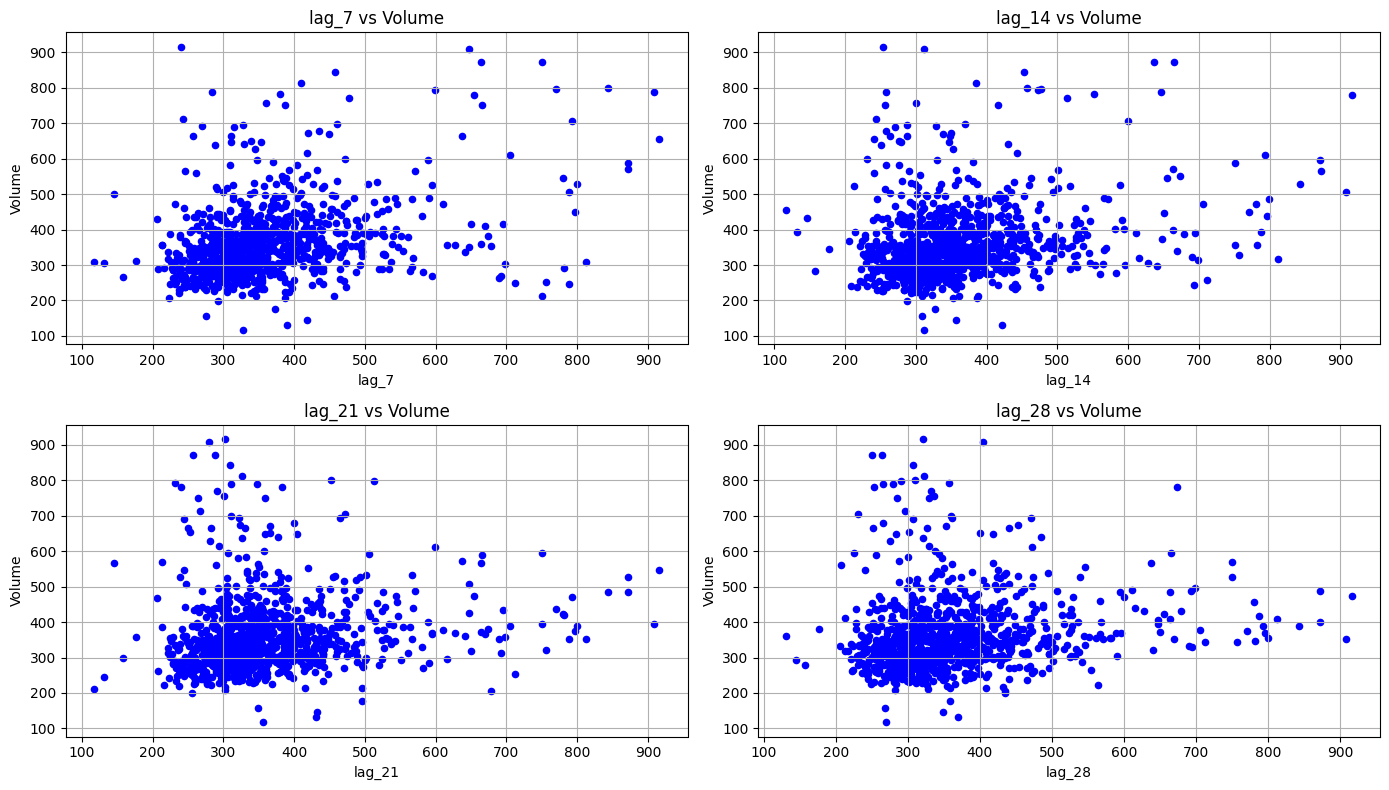

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
lags = ['lag_7', 'lag_14', 'lag_21', 'lag_28']
for i, lag in enumerate(lags):
    row, col = divmod(i, 2)
    axes[row, col].scatter(df_train[lag], df_train['Volume'], color='blue',s=20)
    axes[row, col].set_title(f'{lag} vs Volume')
    axes[row, col].set_xlabel(lag)
    axes[row, col].set_ylabel('Volume')
    axes[row, col].grid(True)
plt.tight_layout()
plt.show()

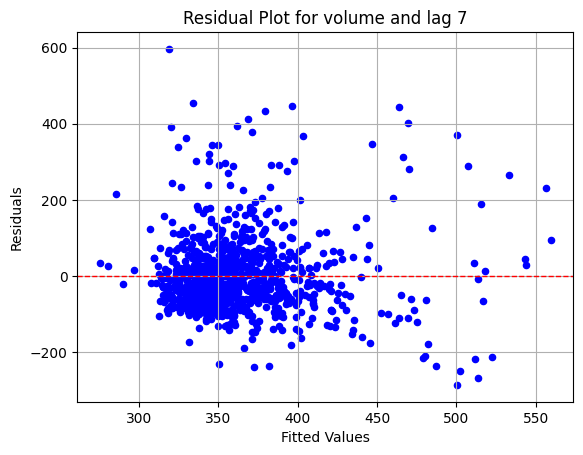

In [39]:
from statsmodels.stats.diagnostic import het_breuschpagan

X = df_train[['lag_7']]
y = df_train['Volume']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
residuals = model.resid
plt.scatter(model.fittedvalues, residuals, color='blue', s=20)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residual Plot for volume and lag 7')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

In [40]:
Tbl = pd.DataFrame({'lag 7': df_train['lag_7'], 'Volume': df_train['Volume']})
tau = [0.25, 0.5, 0.75]
quantiles = []
for q in tau:
    model = sm.QuantReg(Tbl['Volume'], sm.add_constant(Tbl['lag 7']))
    res = model.fit(q=q)
    pred_q = res.predict(sm.add_constant(Tbl['lag 7']))
    quantiles.append(pred_q)
quartiles = np.column_stack(quantiles)
iqr = quartiles[:, 2] - quartiles[:, 0]
k = .5
f1 = quartiles[:, 0] - k * iqr
f2 = quartiles[:, 2] + k * iqr
df_train['f1'] = f1
df_train['f2'] = f2
df_train['anomaly_qr'] = np.where((df_train['Volume'] < df_train['f1']) |
                               (df_train['Volume'] > df_train['f2']), 1, 0)

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning:

Maximum number of iterations (1000) reached.



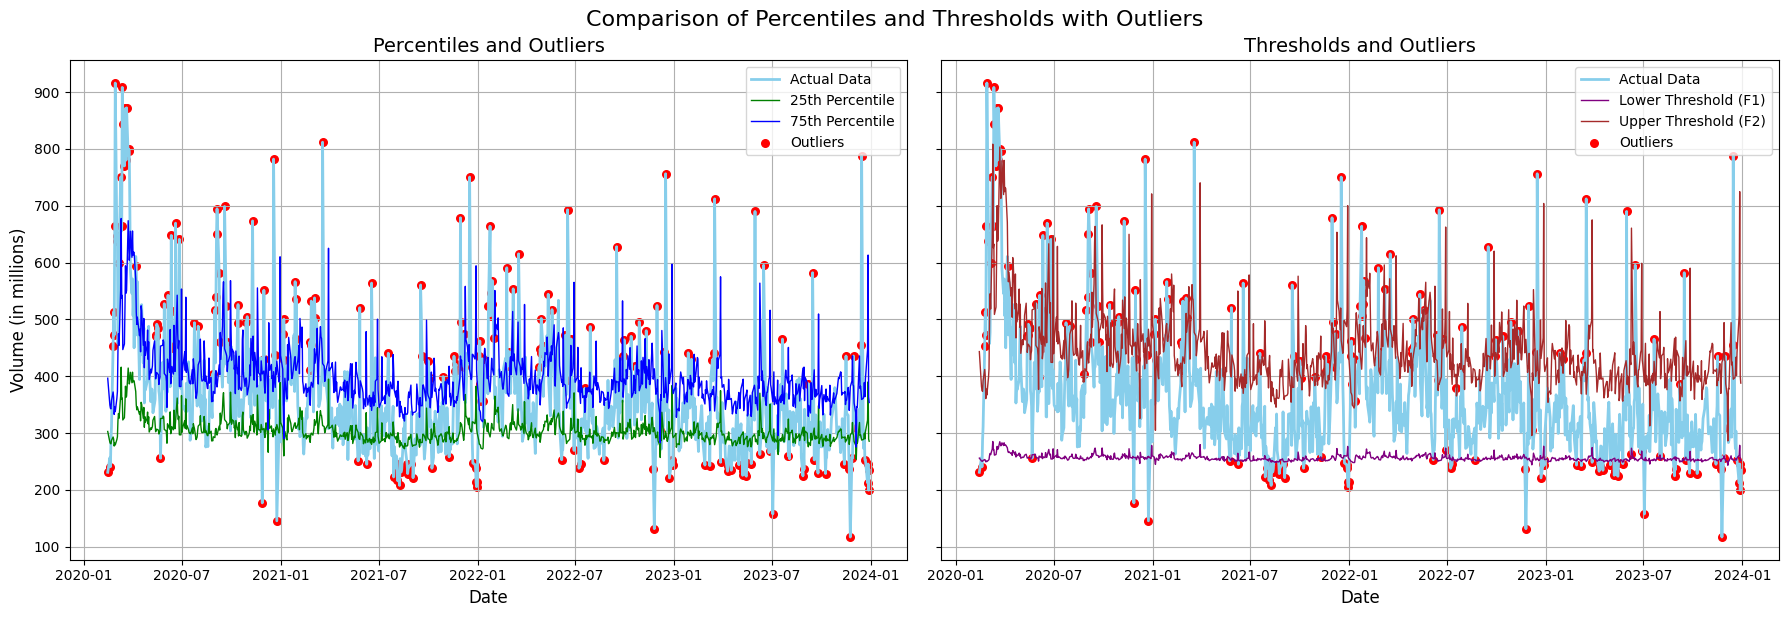

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
axes[0].plot(df_train['Date'], df_train['Volume'], label='Actual Data', color='skyblue', linewidth=2)
axes[0].plot(df_train['Date'], quartiles[:, 0], label='25th Percentile', color='green', linewidth=1)
axes[0].plot(df_train['Date'], quartiles[:, 2], label='75th Percentile', color='blue', linewidth=1)
outliers_left = df_train[df_train['anomaly_qr'] == 1]
axes[0].scatter(outliers_left['Date'], outliers_left['Volume'], color='red', label='Outliers', s=30)
axes[0].set_title("Percentiles and Outliers", fontsize=14)
axes[0].set_xlabel("Date", fontsize=12)
axes[0].set_ylabel("Volume (in millions)", fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True)
axes[1].plot(df_train['Date'], df_train['Volume'], label='Actual Data', color='skyblue', linewidth=2)
axes[1].plot(df_train['Date'], df_train['f1'], label='Lower Threshold (F1)', color='purple', linewidth=1)
axes[1].plot(df_train['Date'], df_train['f2'], label='Upper Threshold (F2)', color='brown', linewidth=1)
outliers_right = df_train[df_train['anomaly_qr'] == 1]
axes[1].scatter(outliers_right['Date'], outliers_right['Volume'], color='red', label='Outliers', s=30)
axes[1].set_title("Thresholds and Outliers", fontsize=14)
axes[1].set_xlabel("Date", fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True)
plt.tight_layout()
plt.suptitle("Comparison of Percentiles and Thresholds with Outliers", fontsize=16, y=1.02)
plt.show()


Evaluation Metrics:
F1 Score: 0.72
Precision: 0.60
Recall: 0.91
Accuracy: 0.90


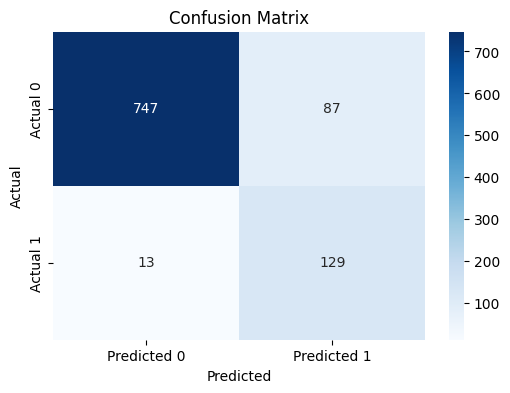

In [42]:
true_labels = df_train["Flag"]
predicted_labels = df_train["anomaly_qr"]
cm = confusion_matrix(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
print("\nEvaluation Metrics:")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Accuracy: {accuracy:.2f}")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [43]:
Tbl = pd.DataFrame({'lag 7': df_test['lag_7'], 'Volume': df_test['Volume']})
tau = [0.25, 0.5, 0.75]
quantiles = []
for q in tau:
    model = sm.QuantReg(Tbl['Volume'], sm.add_constant(Tbl['lag 7']))
    res = model.fit(q=q)
    pred_q = res.predict(sm.add_constant(Tbl['lag 7']))
    quantiles.append(pred_q)
quartiles = np.column_stack(quantiles)
iqr = quartiles[:, 2] - quartiles[:, 0]
f1 = quartiles[:, 0] - k * iqr
f2 = quartiles[:, 2] + k * iqr
df_test['f1'] = f1
df_test['f2'] = f2
df_test['anomaly_qr'] = np.where((df_test['Volume'] < df_test['f1']) |
                               (df_test['Volume'] > df_test['f2']), 1, 0)

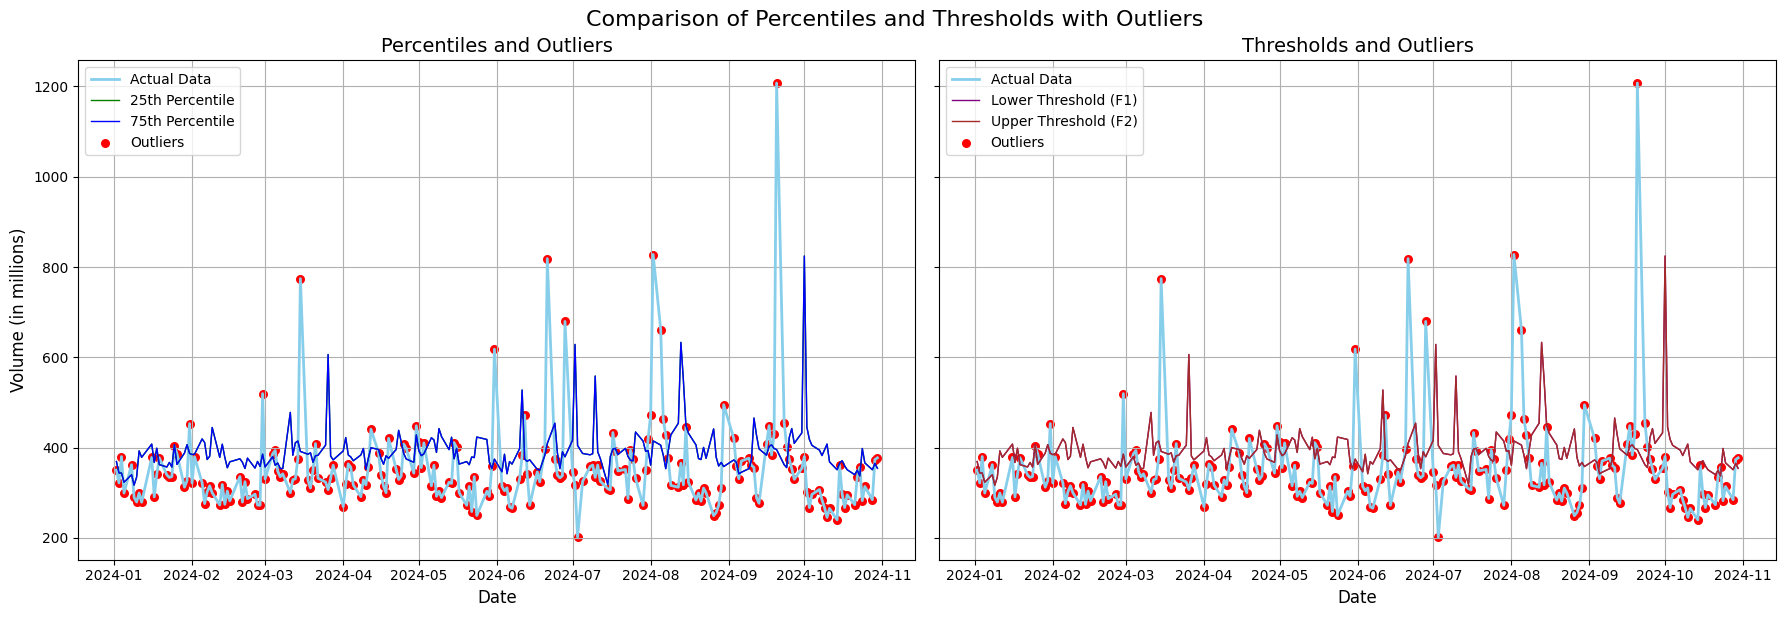

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
axes[0].plot(df_test['Date'], df_test['Volume'], label='Actual Data', color='skyblue', linewidth=2)
axes[0].plot(df_test['Date'], quartiles[:, 0], label='25th Percentile', color='green', linewidth=1)
axes[0].plot(df_test['Date'], quartiles[:, 2], label='75th Percentile', color='blue', linewidth=1)
outliers_left = df_test[df_test['anomaly_qr'] == 1]
axes[0].scatter(outliers_left['Date'], outliers_left['Volume'], color='red', label='Outliers', s=30)
axes[0].set_title("Percentiles and Outliers", fontsize=14)
axes[0].set_xlabel("Date", fontsize=12)
axes[0].set_ylabel("Volume (in millions)", fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True)
axes[1].plot(df_test['Date'], df_test['Volume'], label='Actual Data', color='skyblue', linewidth=2)
axes[1].plot(df_test['Date'], df_test['f1'], label='Lower Threshold (F1)', color='purple', linewidth=1)
axes[1].plot(df_test['Date'], df_test['f2'], label='Upper Threshold (F2)', color='brown', linewidth=1)
outliers_right = df_test[df_test['anomaly_qr'] == 1]
axes[1].scatter(outliers_right['Date'], outliers_right['Volume'], color='red', label='Outliers', s=30)
axes[1].set_title("Thresholds and Outliers", fontsize=14)
axes[1].set_xlabel("Date", fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True)
plt.tight_layout()
plt.suptitle("Comparison of Percentiles and Thresholds with Outliers", fontsize=16, y=1.02)
plt.show()


Evaluation Metrics:
F1 Score: 0.12
Precision: 0.06
Recall: 1.00
Accuracy: 0.06


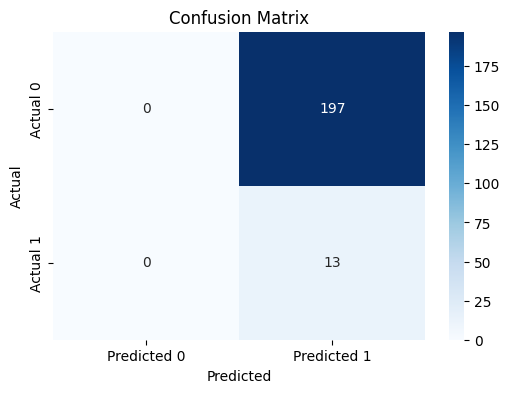

In [45]:
true_labels = df_test["Flag"]
predicted_labels = df_test["anomaly_qr"]
cm = confusion_matrix(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
print("\nEvaluation Metrics:")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Accuracy: {accuracy:.2f}")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [46]:
def evaluate_model(true_labels, predicted_labels):
    f1 = f1_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    return f1, precision, recall, accuracy
test_true_labels = df_test["Flag"]
test_predicted_labels = df_test["anomaly_qr"]
test_metrics = evaluate_model(test_true_labels, test_predicted_labels)
train_true_labels = df_train["Flag"]
train_predicted_labels = df_train["anomaly_qr"]
train_metrics = evaluate_model(train_true_labels, train_predicted_labels)
metrics = pd.DataFrame({
    "Model": ["Quantile Regression AD", "Quantile Regression AD"],
    "Data": ["Train", "Test"],
    "F1 Score": [train_metrics[0], test_metrics[0]],
    "Precision": [train_metrics[1], test_metrics[1]],
    "Recall": [train_metrics[2], test_metrics[2]],
    "Accuracy": [train_metrics[3], test_metrics[3]]})
df_metrics=pd.concat([df_metrics,metrics],axis=0)
df_metrics

,Model,Data,F1 Score,Precision,Recall,Accuracy
0,Quantile AD,Train,0.835735,0.717822,1.000000,0.943340
1,Quantile AD,Test,0.896552,0.812500,1.000000,0.985714
0,ESD AD,Train,0.209877,1.000000,0.117241,0.872763
1,ESD AD,Test,0.470588,1.000000,0.307692,0.957143
0,Isolation Forest AD,Train,0.771186,1.000000,0.627586,0.946322
1,Isolation Forest AD,Test,0.818182,1.000000,0.692308,0.980952
0,Isolation Forest (Conformal) AD,Train,0.675799,1.000000,0.510345,0.929423
1,Isolation Forest (Conformal) AD,Test,0.761905,1.000000,0.615385,0.976190
0,One Class SVM AD,Train,0.831081,0.814570,0.848276,0.950298
1,One Class SVM AD,Test,0.923077,0.923077,0.923077,0.990476


# Summary

In [47]:
desired_order = [
    "ESD AD", "Quantile AD",
    "Isolation Forest AD", "Isolation Forest (Conformal) AD",
    "One Class SVM AD", "One Class SVM (Conformal) AD",
    "Quantile Regression AD"]
df_metrics["F1 Score"] = df_metrics["F1 Score"].round(2)
df_metrics["Precision"] = df_metrics["Precision"].round(2)
df_metrics["Recall"] = df_metrics["Recall"].round(2)
df_metrics["Accuracy"] = df_metrics["Accuracy"].round(2)
df_metrics["Model"] = pd.Categorical(df_metrics["Model"], categories=desired_order, ordered=True)
df_metrics = df_metrics.sort_values(by=["Model", "Data"]).reset_index(drop=True)
df_metrics["Model"] = df_metrics["Model"].str.replace(" AD", "", regex=False)
type_mapping = {
    "ESD": "Rule-based",
    "Quantile": "Rule-based",
    "Quantile Regression": "Regression",
    "Isolation Forest": "Unsupervised",
    "Isolation Forest (Conformal)": "Conformal",
    "One Class SVM": "Unsupervised",
    "One Class SVM (Conformal)": "Conformal"}
df_metrics["Type"] = df_metrics["Model"].map(type_mapping)
columns_order = ["Model", "Type"] + [col for col in df_metrics.columns if col not in ["Model", "Type"]]
df_metrics = df_metrics[columns_order]
df_metrics

,Model,Type,Data,F1 Score,Precision,Recall,Accuracy
0,ESD,Rule-based,Test,0.47,1.00,0.31,0.96
1,ESD,Rule-based,Train,0.21,1.00,0.12,0.87
2,Quantile,Rule-based,Test,0.90,0.81,1.00,0.99
3,Quantile,Rule-based,Train,0.84,0.72,1.00,0.94
4,Isolation Forest,Unsupervised,Test,0.82,1.00,0.69,0.98
5,Isolation Forest,Unsupervised,Train,0.77,1.00,0.63,0.95
6,Isolation Forest (Conformal),Conformal,Test,0.76,1.00,0.62,0.98
7,Isolation Forest (Conformal),Conformal,Train,0.68,1.00,0.51,0.93
8,One Class SVM,Unsupervised,Test,0.92,0.92,0.92,0.99
9,One Class SVM,Unsupervised,Train,0.83,0.81,0.85,0.95


<ipython-input-48-233961f17089>:7: UserWarning:

The palette list has more values (10) than needed (2), which may not be intended.

<ipython-input-48-233961f17089>:22: UserWarning:

The palette list has more values (10) than needed (2), which may not be intended.



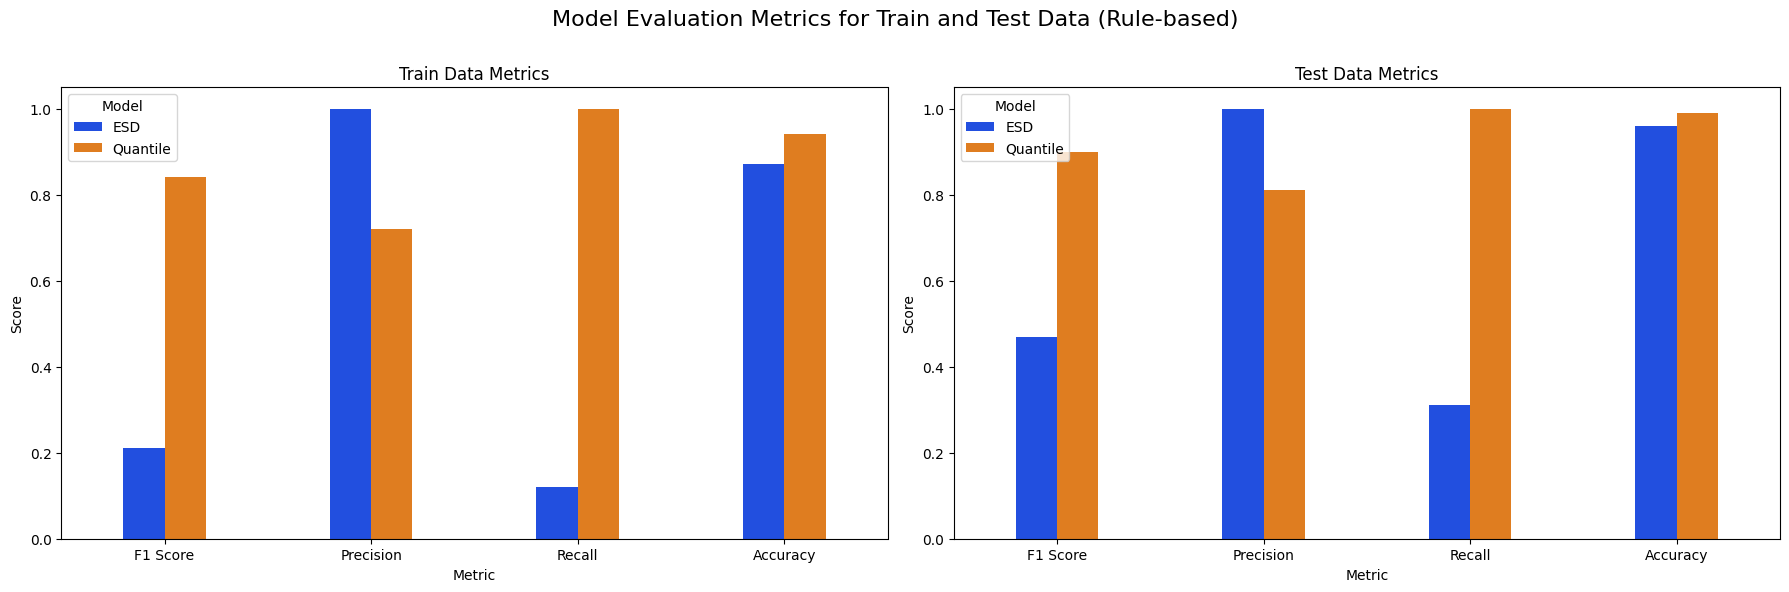

In [48]:
df_metrics1 = df_metrics[df_metrics["Type"] == "Rule-based"]
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
custom_palette = sns.color_palette("bright")
train_data = df_metrics1[df_metrics1["Data"] == "Train"].melt(
    id_vars=["Model"], value_vars=["F1 Score", "Precision", "Recall", "Accuracy"],
    var_name="Metric", value_name="Value")
sns.barplot(
    data=train_data,
    x="Metric",
    y="Value",
    hue="Model",
    palette=custom_palette,
    ax=axes[0],
    width=0.4  )
axes[0].set_title("Train Data Metrics")
axes[0].set_xlabel("Metric")
axes[0].set_ylabel("Score")
axes[0].legend(title="Model", loc='upper left')
test_data = df_metrics1[df_metrics1["Data"] == "Test"].melt(
    id_vars=["Model"], value_vars=["F1 Score", "Precision", "Recall", "Accuracy"],
    var_name="Metric", value_name="Value")
sns.barplot(
    data=test_data,
    x="Metric",
    y="Value",
    hue="Model",
    palette=custom_palette,
    ax=axes[1],
    width=0.4 )
axes[1].set_title("Test Data Metrics")
axes[1].set_xlabel("Metric")
axes[1].set_ylabel("Score")
axes[1].legend(title="Model", loc='upper left')
fig.tight_layout()
fig.suptitle("Model Evaluation Metrics for Train and Test Data (Rule-based)", fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

<ipython-input-49-b03c13743a82>:7: UserWarning:

The palette list has more values (10) than needed (1), which may not be intended.

<ipython-input-49-b03c13743a82>:22: UserWarning:

The palette list has more values (10) than needed (1), which may not be intended.



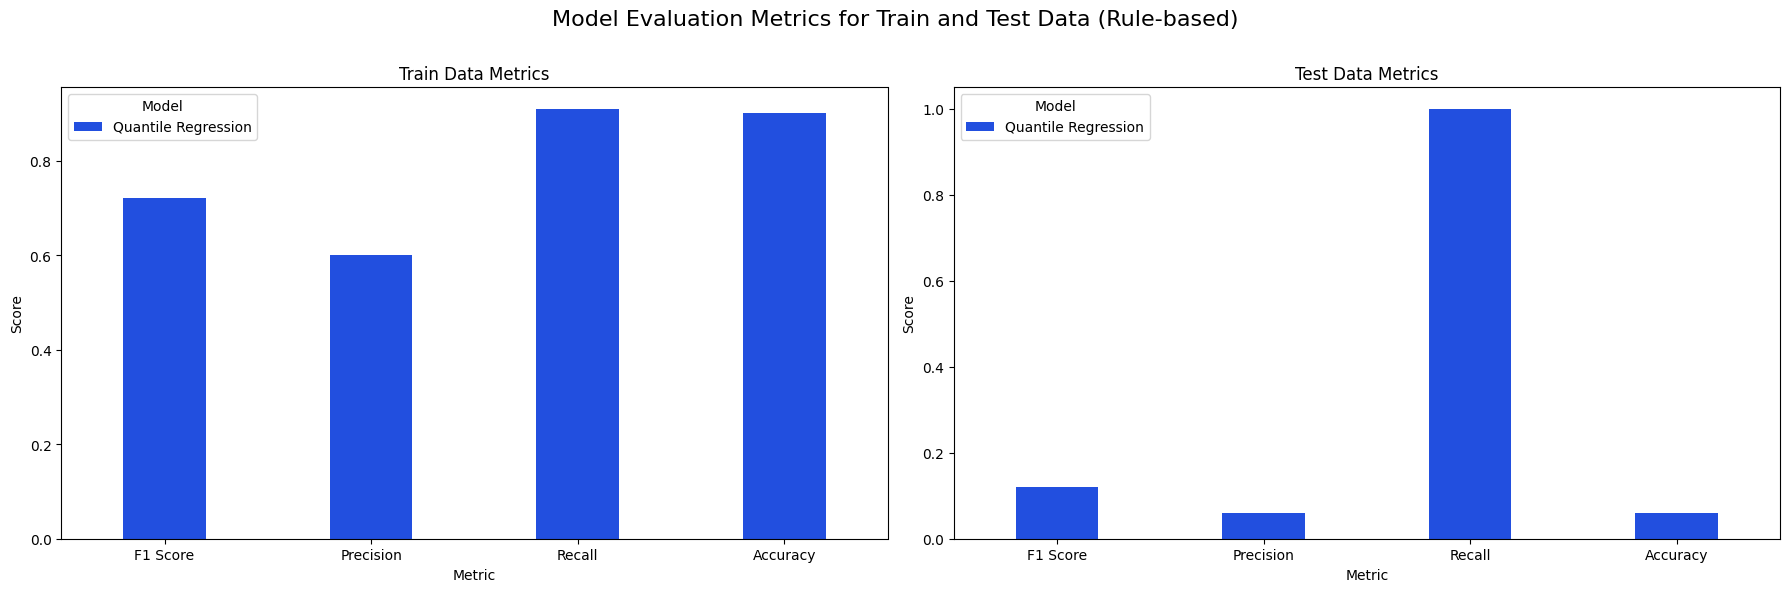

In [49]:
df_metrics1 = df_metrics[df_metrics["Type"] == "Regression"]
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
custom_palette = sns.color_palette("bright")
train_data = df_metrics1[df_metrics1["Data"] == "Train"].melt(
    id_vars=["Model"], value_vars=["F1 Score", "Precision", "Recall", "Accuracy"],
    var_name="Metric", value_name="Value")
sns.barplot(
    data=train_data,
    x="Metric",
    y="Value",
    hue="Model",
    palette=custom_palette,
    ax=axes[0],
    width=0.4  )
axes[0].set_title("Train Data Metrics")
axes[0].set_xlabel("Metric")
axes[0].set_ylabel("Score")
axes[0].legend(title="Model", loc='upper left')
test_data = df_metrics1[df_metrics1["Data"] == "Test"].melt(
    id_vars=["Model"], value_vars=["F1 Score", "Precision", "Recall", "Accuracy"],
    var_name="Metric", value_name="Value")
sns.barplot(
    data=test_data,
    x="Metric",
    y="Value",
    hue="Model",
    palette=custom_palette,
    ax=axes[1],
    width=0.4 )
axes[1].set_title("Test Data Metrics")
axes[1].set_xlabel("Metric")
axes[1].set_ylabel("Score")
axes[1].legend(title="Model", loc='upper left')
fig.tight_layout()
fig.suptitle("Model Evaluation Metrics for Train and Test Data (Rule-based)", fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

<ipython-input-50-8e1322a2ace9>:7: UserWarning:

The palette list has more values (10) than needed (2), which may not be intended.

<ipython-input-50-8e1322a2ace9>:22: UserWarning:

The palette list has more values (10) than needed (2), which may not be intended.



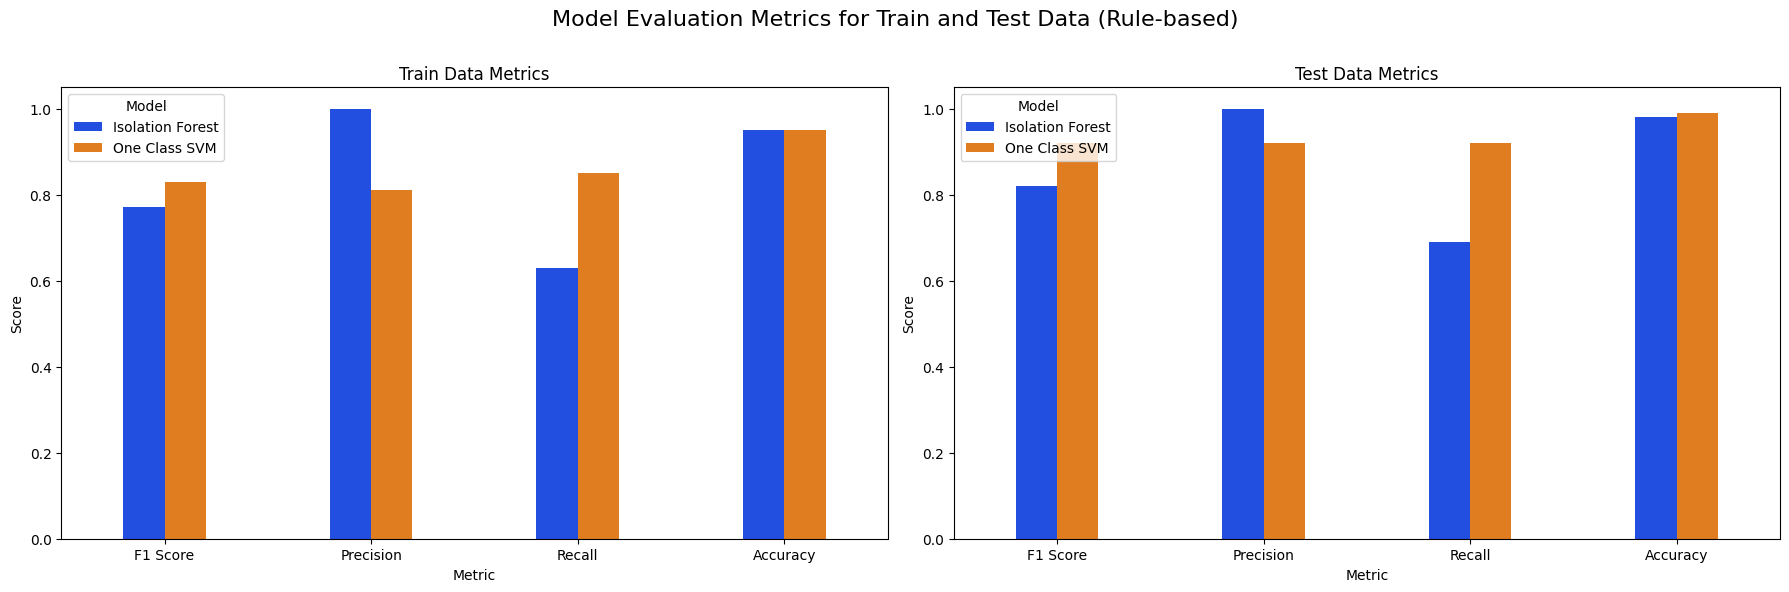

In [50]:
df_metrics1 = df_metrics[df_metrics["Type"] == "Unsupervised"]
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
custom_palette = sns.color_palette("bright")
train_data = df_metrics1[df_metrics1["Data"] == "Train"].melt(
    id_vars=["Model"], value_vars=["F1 Score", "Precision", "Recall", "Accuracy"],
    var_name="Metric", value_name="Value")
sns.barplot(
    data=train_data,
    x="Metric",
    y="Value",
    hue="Model",
    palette=custom_palette,
    ax=axes[0],
    width=0.4 )
axes[0].set_title("Train Data Metrics")
axes[0].set_xlabel("Metric")
axes[0].set_ylabel("Score")
axes[0].legend(title="Model", loc='upper left')
test_data = df_metrics1[df_metrics1["Data"] == "Test"].melt(
    id_vars=["Model"], value_vars=["F1 Score", "Precision", "Recall", "Accuracy"],
    var_name="Metric", value_name="Value")
sns.barplot(
    data=test_data,
    x="Metric",
    y="Value",
    hue="Model",
    palette=custom_palette,
    ax=axes[1],
    width=0.4 )
axes[1].set_title("Test Data Metrics")
axes[1].set_xlabel("Metric")
axes[1].set_ylabel("Score")
axes[1].legend(title="Model", loc='upper left')
fig.tight_layout()
fig.suptitle("Model Evaluation Metrics for Train and Test Data (Rule-based)", fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

<ipython-input-51-0c9ad8190135>:7: UserWarning:

The palette list has more values (10) than needed (2), which may not be intended.

<ipython-input-51-0c9ad8190135>:22: UserWarning:

The palette list has more values (10) than needed (2), which may not be intended.



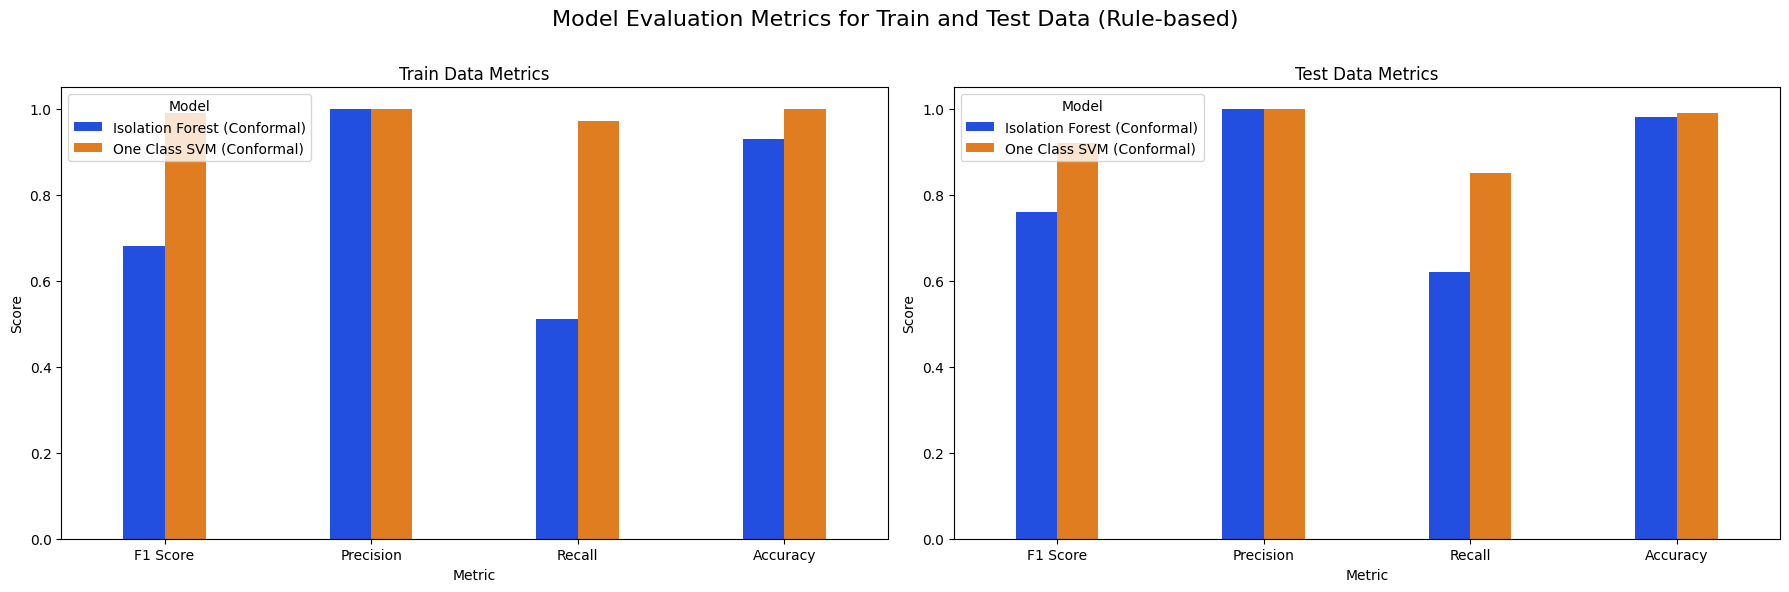

In [51]:
df_metrics1 = df_metrics[df_metrics["Type"] == "Conformal"]
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
custom_palette = sns.color_palette("bright")
train_data = df_metrics1[df_metrics1["Data"] == "Train"].melt(
    id_vars=["Model"], value_vars=["F1 Score", "Precision", "Recall", "Accuracy"],
    var_name="Metric", value_name="Value")
sns.barplot(
    data=train_data,
    x="Metric",
    y="Value",
    hue="Model",
    palette=custom_palette,
    ax=axes[0],
    width=0.4 )
axes[0].set_title("Train Data Metrics")
axes[0].set_xlabel("Metric")
axes[0].set_ylabel("Score")
axes[0].legend(title="Model", loc='upper left')
test_data = df_metrics1[df_metrics1["Data"] == "Test"].melt(
    id_vars=["Model"], value_vars=["F1 Score", "Precision", "Recall", "Accuracy"],
    var_name="Metric", value_name="Value")
sns.barplot(
    data=test_data,
    x="Metric",
    y="Value",
    hue="Model",
    palette=custom_palette,
    ax=axes[1],
    width=0.4  )
axes[1].set_title("Test Data Metrics")
axes[1].set_xlabel("Metric")
axes[1].set_ylabel("Score")
axes[1].legend(title="Model", loc='upper left')
fig.tight_layout()
fig.suptitle("Model Evaluation Metrics for Train and Test Data (Rule-based)", fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

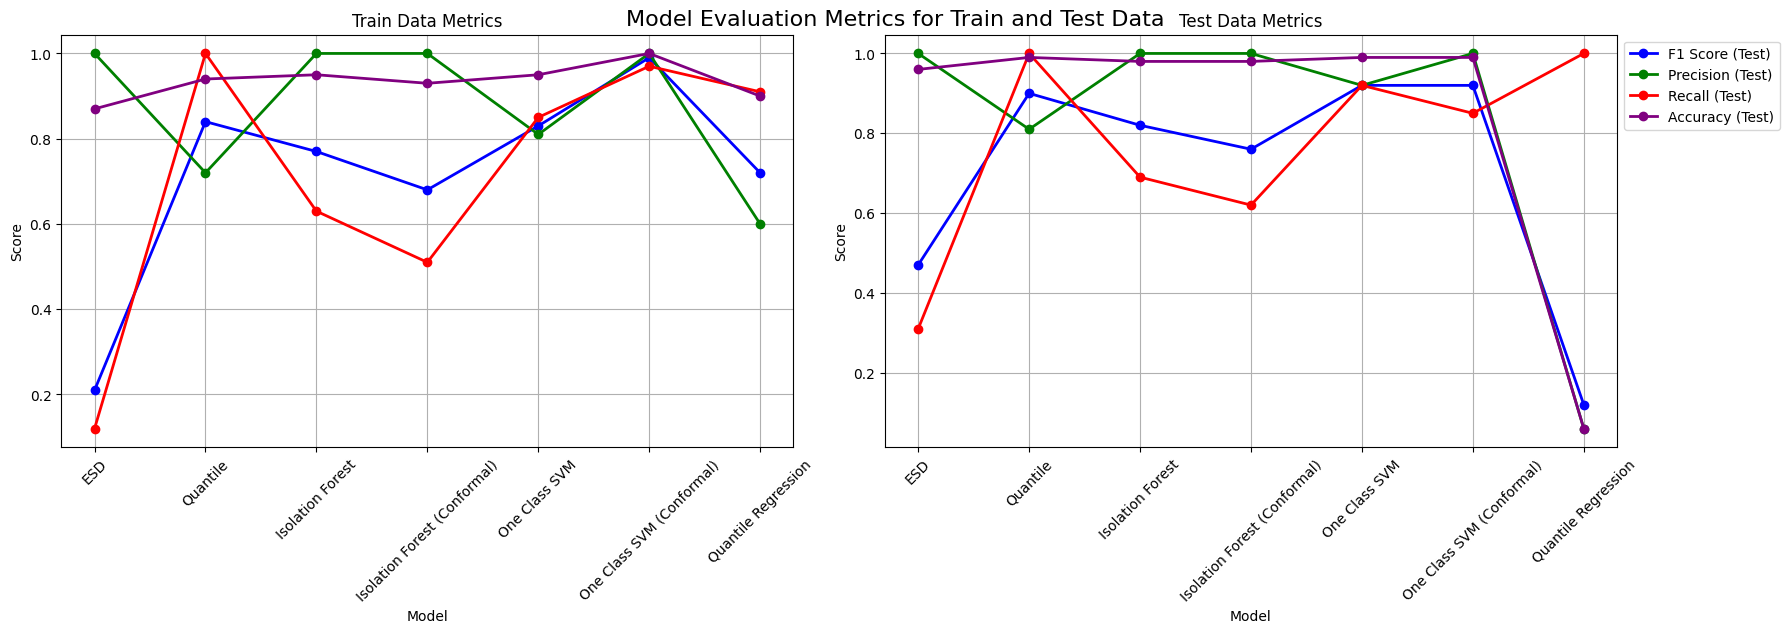

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
train_data = df_metrics[df_metrics["Data"] == "Train"]
axes[0].plot(train_data["Model"], train_data["F1 Score"], marker='o', color='blue', label="F1 Score (Train)", linewidth=2)
axes[0].plot(train_data["Model"], train_data["Precision"], marker='o', color='green', label="Precision (Train)", linewidth=2)
axes[0].plot(train_data["Model"], train_data["Recall"], marker='o', color='red', label="Recall (Train)", linewidth=2)
axes[0].plot(train_data["Model"], train_data["Accuracy"], marker='o', color='purple', label="Accuracy (Train)", linewidth=2)
axes[0].set_title("Train Data Metrics")
axes[0].set_xlabel("Model")
axes[0].set_ylabel("Score")
axes[0].grid(True)
test_data = df_metrics[df_metrics["Data"] == "Test"]
axes[1].plot(test_data["Model"], test_data["F1 Score"], marker='o', color='blue', label="F1 Score (Test)", linewidth=2)
axes[1].plot(test_data["Model"], test_data["Precision"], marker='o', color='green', label="Precision (Test)", linewidth=2)
axes[1].plot(test_data["Model"], test_data["Recall"], marker='o', color='red', label="Recall (Test)", linewidth=2)
axes[1].plot(test_data["Model"], test_data["Accuracy"], marker='o', color='purple', label="Accuracy (Test)", linewidth=2)
axes[1].set_title("Test Data Metrics")
axes[1].set_xlabel("Model")
axes[1].set_ylabel("Score")
axes[1].grid(True)
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
for ax in axes:
    ax.tick_params(axis="x", rotation=45)
fig.tight_layout()
fig.suptitle("Model Evaluation Metrics for Train and Test Data", fontsize=16)
plt.subplots_adjust(bottom=0.25)
plt.show()